# Earthquake_prac_3
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigenvalue deposition]

In [792]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium
from IPython.display import HTML

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

**대지진 순위중 일부 추출**

In [3]:
pd.read_html('https://ko.wikipedia.org/wiki/%EC%A7%80%EC%A7%84_%EB%AA%A9%EB%A1%9D',encoding='utf-8')[1].iloc[[2,3,8],:]

,순위,일자,장소,이름,규모
2,3,2004년 12월 26일,인도네시아 수마트라섬,2004년 인도양 지진 해일,9.1-9.3
3,4,2011년 3월 11일,일본 산리쿠 해역,2011년 도호쿠 지방 태평양 앞바다 지진,9.1
8,6 (공동),2010년 2월 27일,칠레 마울레주 해역,2010년 칠레 지진,8.8


- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [4]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2004" & Year<="2011"').reset_index().iloc[:,1:]
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4517 entries, 0 to 4516
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4517 non-null   object 
 1   Latitude   4517 non-null   float64
 2   Longitude  4517 non-null   float64
 3   Magnitude  4517 non-null   float64
 4   Year       4517 non-null   object 
dtypes: float64(3), object(2)
memory usage: 176.6+ KB


<AxesSubplot:>

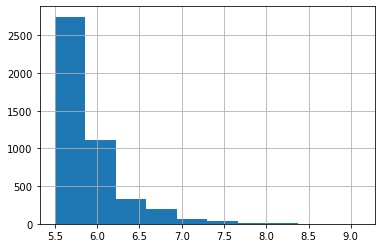

In [5]:
_df.Magnitude.hist()

##### 2. $f(x) = y$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [6]:
f = _df.loc[:,"Magnitude"]

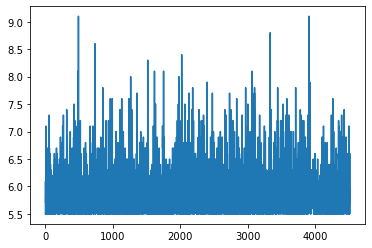

In [7]:
#collapse
plt.plot(f,'-')

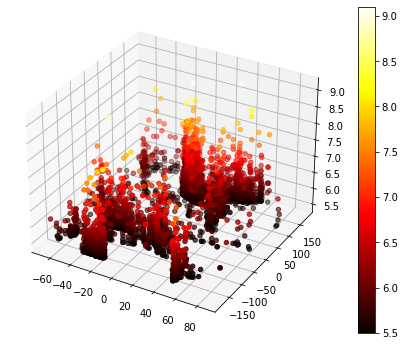

In [8]:
#collapse
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude, c= _df.Magnitude,  cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [9]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2011-2010)]

In [10]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [11]:
#collapse
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(2010,2011))).add_to(m)
m

##### 3. 비유클리드 공간에서의 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{(x_j-x_i)^2+(y_j-y_i)^2}$$

In [12]:
def dist(i,j):
    a1=abs(_df.Latitude[j] - _df.Latitude[i])
    a2=abs(_df.Latitude[j] + _df.Latitude[i])
    b1=abs(_df.Longitude[j] - _df.Longitude[i])
    b2=abs(_df.Longitude[j] + _df.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

---

**하버사인haversine 공식 사용**

- $φ_1$, $φ_2$ are the latitude of point 1 and latitude of point 2,
- $λ_1$, $λ_2$ are the longitude of point 1 and longitude of point 2.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/8390236068c8e84f9fea2729c76a21ec3574a7db)

In [13]:
from haversine import haversine

In [14]:
def dist1(i,j):
    return haversine((_df.Latitude[i],_df.Longitude[i]),(_df.Latitude[j],_df.Longitude[j]))

In [15]:
def weight4(i,j,theta=50000,kappa=100000):
    return np.exp( -np.abs(dist1(i,j))**2 / (2*theta**2) ) if dist1(i,j) <= kappa else 0

In [16]:
def weight5(i,j,theta=75000,kappa=100000):
    return np.exp( -np.abs(dist1(i,j))**2 / (2*theta**2) ) if dist1(i,j) <= kappa else 0

In [17]:
def weight6(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(dist1(i,j))**2 / (2*theta**2) ) if dist1(i,j) <= kappa else 0

##### 4. 거리를 이용한 a weighted adjacency matrix $W_{i,j}$ 정의

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [18]:
def weight1(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [19]:
def weight2(i,j,theta=90,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [733]:
def weight3(i,j,theta=100,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

```python
a=[]
for i in range(1000**2):
    a.append(i)

a=np.array(a)
np.save(file="./add",arr=a)
```

In [21]:
W1= np.array([[weight1(i,j) for i in range(len(_df))] for j in range(len(_df))])

```python
aa=np.load('./add.npy')
aa.to
np.save(file="./mysave",arr=W1)
```

In [22]:
W2 = np.array([[weight2(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [23]:
W3 = np.array([[weight3(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [24]:
W4 = np.array([[weight4(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [25]:
W5 = np.array([[weight5(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [26]:
W6 = np.array([[weight6(i,j) for i in range(len(_df))] for j in range(len(_df))])

---

In [746]:
def weight_z(i,j,theta=100,kappa=1000):
    return np.exp( -np.abs(dist_z(i,j))**2 / (2*theta**2) ) if dist_z(i,j) <= kappa else 0

In [747]:
W_z = np.array([[weight_z(i,j) for i in range(len(_df))] for j in range(len(_df))])

---

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [27]:
D1 = np.diag(W1.sum(axis=1))

In [28]:
D2 = np.diag(W2.sum(axis=1))

In [29]:
D3 = np.diag(W3.sum(axis=1))

In [30]:
D4 = np.diag(W4.sum(axis=1))

In [31]:
D5 = np.diag(W5.sum(axis=1))

In [32]:
D6 = np.diag(W6.sum(axis=1))

---

In [748]:
D_z = np.diag(W_z.sum(axis=1))

---

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [33]:
L1 = D1 - W1

In [34]:
L2 = D2 - W2

In [35]:
L3 = D3 - W3

In [36]:
L4 = D4 - W4

In [37]:
L5 = D5 - W5

In [38]:
L6 = D6 - W6

---

In [749]:
L_z = D_z - W_z

---

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [39]:
λ1, Ψ1 = np.linalg.eig(L1)

In [40]:
Λ1 = np.diag(λ1)

In [41]:
λ2, Ψ2 = np.linalg.eig(L2)

In [42]:
Λ2 = np.diag(λ2)

In [43]:
λ3, Ψ3 = np.linalg.eig(L3)

In [44]:
Λ3 = np.diag(λ3)

In [45]:
λ4, Ψ4 = np.linalg.eig(L4)

In [46]:
Λ4 = np.diag(λ4)

In [47]:
λ5, Ψ5 = np.linalg.eig(L5)

In [48]:
Λ5 = np.diag(λ5)

In [49]:
λ6, Ψ6 = np.linalg.eig(L6)

In [50]:
Λ6 = np.diag(λ6)

---

In [750]:
λ_z, Ψ_z = np.linalg.eig(L_z)

In [751]:
Λ_z = np.diag(λ_z)

---

##### 8. 주성분 분석
- $comp_k = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
        - $f = n \times 1 , np.outer(Ψ[:,k], Ψ[:,k]) = n \times n, \\ \therefore comp_k = n \times n$
- $p = \sum_{1}^{n} comp_{1}^{2},\sum_{1}^{n} comp_{2}^{2},…,\sum_{1}^{n} comp_{n}^{2}$
- $p = \frac{p}{\sum(p)}$

In [51]:
def comp1(i):
    return (f @ np.outer( Ψ1[:,i], Ψ1[:,i]))

In [52]:
def p1(i):
    return sum(comp1(i)**2)

In [53]:
array_11 = np.array([p1(i) for i in range(1,len(_df))])

In [54]:
varprop1 = array_11/array_11.sum()

In [55]:
#collapse
_index1 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop1}).sort_values('varprop',ascending=False)
_indexlst1 = _index1.iloc[:25,0].tolist()

In [56]:
def comp2(i):
    return (f @ np.outer( Ψ2[:,i], Ψ2[:,i]))

In [57]:
def p2(i):
    return sum(comp2(i)**2)

In [58]:
array_12 = np.array([p2(i) for i in range(1,len(_df))])

In [59]:
varprop2 = array_12/array_12.sum()

In [60]:
#collapse
_index2 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop2}).sort_values('varprop',ascending=False)
_indexlst2 = _index2.iloc[:25,0].tolist()

In [61]:
def comp3(i):
    return (f @ np.outer( Ψ3[:,i], Ψ3[:,i]))

In [62]:
def p3(i):
    return sum(comp3(i)**2)

In [63]:
array_13 = np.array([p3(i) for i in range(1,len(_df))])

In [64]:
varprop3 = array_13/array_13.sum()

In [65]:
#collapse
_index3 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop3}).sort_values('varprop',ascending=False)
_indexlst3 = _index3.iloc[:25,0].tolist()

In [66]:
def comp4(i):
    return (f @ np.outer( Ψ4[:,i], Ψ4[:,i]))

In [67]:
def p4(i):
    return sum(comp4(i)**2)

In [68]:
array_14 = np.array([p4(i) for i in range(1,len(_df))])

In [69]:
varprop4 = array_14/array_14.sum()

In [70]:
#collapse
_index4 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop4}).sort_values('varprop',ascending=False)
_indexlst4 = _index4.iloc[:25,0].tolist()

In [71]:
def comp5(i):
    return (f @ np.outer( Ψ5[:,i], Ψ5[:,i]))

In [72]:
def p5(i):
    return sum(comp5(i)**2)

In [343]:
array_15 = np.array([p5(i) for i in range(1,len(_df))])

In [344]:
varprop5 = array_15/array_15.sum()

In [345]:
#collapse
_index5 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop5}).sort_values('varprop',ascending=False)
_indexlst5 = _index5.iloc[:25,0].tolist()

In [346]:
def comp6(i):
    return (f @ np.outer( Ψ6[:,i], Ψ6[:,i]))

In [347]:
def p6(i):
    return sum(comp6(i)**2)

In [348]:
array_16 = np.array([p6(i) for i in range(1,len(_df))])

In [349]:
varprop6 = array_16/array_16.sum()

In [350]:
#collapse
_index6 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop6}).sort_values('varprop',ascending=False)
_indexlst6 = _index6.iloc[:25,0].tolist()

---

In [753]:
def comp_z(i):
    return (f @ np.outer( Ψ_z[:,i], Ψ_z[:,i]))

In [754]:
def p_z(i):
    return sum(comp_z(i)**2)

In [755]:
array_1_z = np.array([p_z(i) for i in range(1,len(_df))])

In [756]:
varprop_z = array_1_z/array_1_z.sum()

In [757]:
#collapse
_index_z = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop_z}).sort_values('varprop',ascending=False)
_indexlst_z = _index_z.iloc[:25,0].tolist()

---

##### 9. PCA

In [351]:
comp11 = f @ np.outer( Ψ1[:,0], Ψ1[:,0])

In [352]:
comp21 = f @ np.outer( Ψ1[:,_indexlst1[0]], Ψ1[:,_indexlst1[0]])

In [353]:
comp31 = f @ np.outer( Ψ1[:,_indexlst1[1]], Ψ1[:,_indexlst1[1]])

In [354]:
comp41 = f @ np.outer( Ψ1[:,_indexlst1[2]], Ψ1[:,_indexlst1[2]])

In [355]:
comp51 = f @ np.outer( Ψ1[:,_indexlst1[3]], Ψ1[:,_indexlst1[3]])

In [356]:
_df1=_df

In [357]:
_df1["comp1"] = comp11

In [358]:
_df1["comp2"] = comp21

In [359]:
_df1["comp3"] = comp31

In [360]:
_df1["comp4"] = comp41

In [361]:
_df1["comp5"] = comp51

In [362]:
comp12 = f @ np.outer( Ψ2[:,0], Ψ2[:,0])

In [363]:
comp22 = f @ np.outer( Ψ2[:,_indexlst2[0]], Ψ2[:,_indexlst2[0]])

In [364]:
comp32 = f @ np.outer( Ψ2[:,_indexlst2[1]], Ψ2[:,_indexlst2[1]])

In [365]:
comp42 = f @ np.outer( Ψ2[:,_indexlst2[2]], Ψ2[:,_indexlst2[2]])

In [366]:
comp52 = f @ np.outer( Ψ2[:,_indexlst2[3]], Ψ2[:,_indexlst2[3]])

In [367]:
_df2=_df

In [368]:
_df2["comp1"] = comp12

In [369]:
_df2["comp2"] = comp22

In [370]:
_df2["comp3"] = comp32

In [371]:
_df2["comp4"] = comp42

In [372]:
_df2["comp5"] = comp52

In [373]:
comp13 = f @ np.outer( Ψ3[:,0], Ψ3[:,0])

In [374]:
comp23 = f @ np.outer( Ψ3[:,_indexlst3[0]], Ψ3[:,_indexlst3[0]])

In [375]:
comp33 = f @ np.outer( Ψ3[:,_indexlst3[1]], Ψ3[:,_indexlst3[1]])

In [376]:
comp43 = f @ np.outer( Ψ3[:,_indexlst3[2]], Ψ3[:,_indexlst3[2]])

In [377]:
comp53 = f @ np.outer( Ψ3[:,_indexlst3[3]], Ψ3[:,_indexlst3[3]])

In [378]:
_df3 = _df

In [379]:
_df3["comp1"] = comp13

In [380]:
_df3["comp2"] = comp23

In [381]:
_df3["comp3"] = comp33

In [382]:
_df3["comp4"] = comp43

In [383]:
_df3["comp5"] = comp53

In [384]:
comp14 = f @ np.outer( Ψ4[:,0], Ψ4[:,0])

In [385]:
comp24 = f @ np.outer( Ψ4[:,_indexlst4[0]], Ψ4[:,_indexlst4[0]])

In [386]:
comp34 = f @ np.outer( Ψ4[:,_indexlst4[1]], Ψ4[:,_indexlst4[1]])

In [387]:
comp44 = f @ np.outer( Ψ4[:,_indexlst4[2]], Ψ4[:,_indexlst4[2]])

In [388]:
comp54 = f @ np.outer( Ψ4[:,_indexlst4[3]], Ψ4[:,_indexlst4[3]])

In [389]:
_df4 = _df

In [390]:
_df4["comp1"] = comp14

In [391]:
_df4["comp2"] = comp24

In [392]:
_df4["comp3"] = comp34

In [393]:
_df4["comp4"] = comp44

In [394]:
_df4["comp5"] = comp54

In [395]:
comp15 = f @ np.outer( Ψ5[:,0], Ψ5[:,0])

In [396]:
comp25 = f @ np.outer( Ψ5[:,_indexlst5[0]], Ψ3[:,_indexlst5[0]])

In [397]:
comp35 = f @ np.outer( Ψ5[:,_indexlst5[1]], Ψ3[:,_indexlst5[1]])

In [398]:
comp45 = f @ np.outer( Ψ5[:,_indexlst5[2]], Ψ3[:,_indexlst5[2]])

In [399]:
comp55 = f @ np.outer( Ψ5[:,_indexlst5[3]], Ψ3[:,_indexlst5[3]])

In [400]:
_df5 = _df

In [401]:
_df5["comp1"] = comp15

In [402]:
_df5["comp2"] = comp25

In [403]:
_df5["comp3"] = comp35

In [404]:
_df5["comp4"] = comp45

In [405]:
_df5["comp5"] = comp55

In [406]:
comp16 = f @ np.outer( Ψ6[:,0], Ψ6[:,0])

In [407]:
comp26 = f @ np.outer( Ψ6[:,_indexlst6[0]], Ψ6[:,_indexlst6[0]])

In [408]:
comp36 = f @ np.outer( Ψ6[:,_indexlst6[1]], Ψ6[:,_indexlst6[1]])

In [409]:
comp46 = f @ np.outer( Ψ6[:,_indexlst6[2]], Ψ6[:,_indexlst6[2]])

In [410]:
comp56 = f @ np.outer( Ψ6[:,_indexlst6[3]], Ψ6[:,_indexlst6[3]])

In [411]:
_df6 = _df

In [412]:
_df6["comp1"] = comp16

In [413]:
_df6["comp2"] = comp26

In [414]:
_df6["comp3"] = comp36

In [415]:
_df6["comp4"] = comp46

In [416]:
_df6["comp5"] = comp56

---

In [758]:
comp1_z = f @ np.outer( Ψ_z[:,0], Ψ_z[:,0])

In [759]:
comp2_z = f @ np.outer( Ψ_z[:,_indexlst_z[0]], Ψ_z[:,_indexlst_z[0]])

In [760]:
comp3_z = f @ np.outer( Ψ_z[:,_indexlst_z[1]], Ψ_z[:,_indexlst_z[1]])

In [761]:
comp4_z = f @ np.outer( Ψ_z[:,_indexlst_z[2]], Ψ_z[:,_indexlst_z[2]])

In [762]:
comp5_z = f @ np.outer( Ψ_z[:,_indexlst_z[3]], Ψ_z[:,_indexlst_z[3]])

In [763]:
_df_z = _df

In [766]:
_df_z["comp1"] = comp1_z

In [767]:
_df_z["comp2"] = comp2_z

In [768]:
_df_z["comp3"] = comp3_z

In [769]:
_df_z["comp4"] = comp4_z

In [770]:
_df_z["comp5"] = comp5_z

---

##### **$dist$를 이용한 $\theta$ = 80, $\kappa$ = 1000**

In [417]:
_G1 = nx.Graph(W1-np.identity(len(f)))

In [418]:
_pos1 = nx.spring_layout(_G1,iterations=20)

In [419]:
m_pos1 = list(zip(_df1.Longitude,_df1.Latitude))

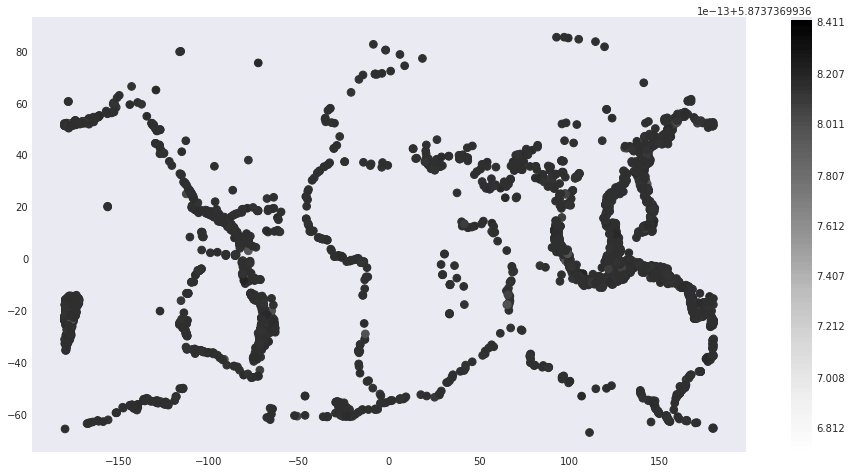

In [420]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df1.comp1,node_size = abs(_df1.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

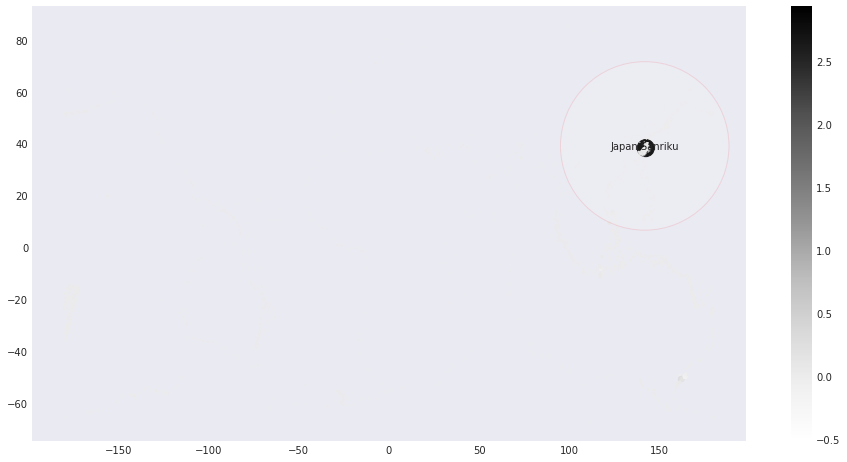

In [421]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df1.comp2,node_size = np.abs(_df1.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

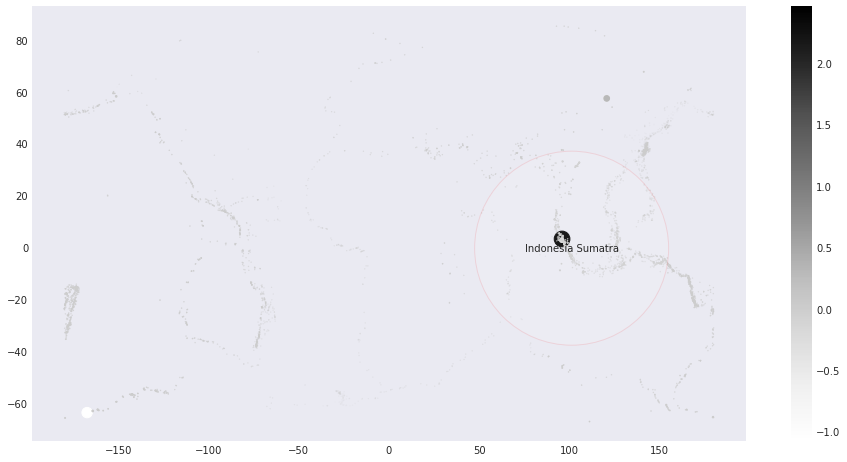

In [422]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df1.comp3,node_size = np.abs(_df1.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

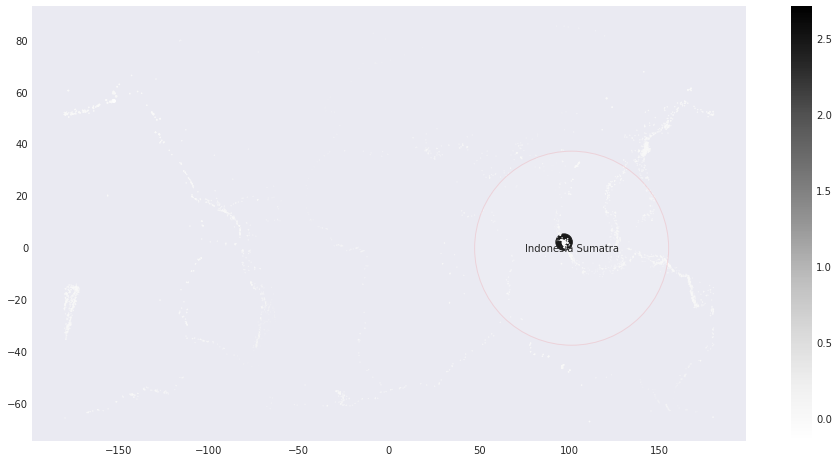

In [423]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df1.comp4,node_size = np.abs(_df1.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

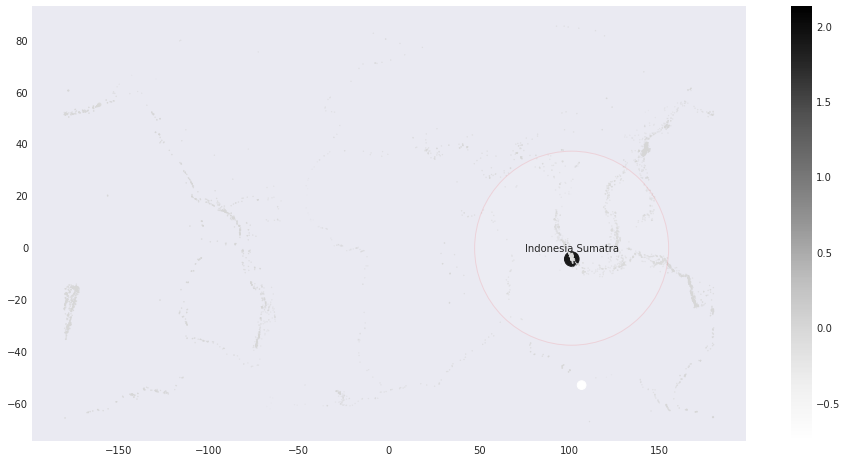

In [424]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df1.comp5,node_size = abs(_df1.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
    #               va="center", ha="center",
    #               bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$dist$를 이용한 $\theta$ = 90, $\kappa$ = 1000**

In [425]:
_G2 = nx.Graph(W2-np.identity(len(f)))

In [426]:
_pos2 = nx.spring_layout(_G2,iterations=20)

In [427]:
m_pos2 = list(zip(_df2.Longitude,_df2.Latitude))

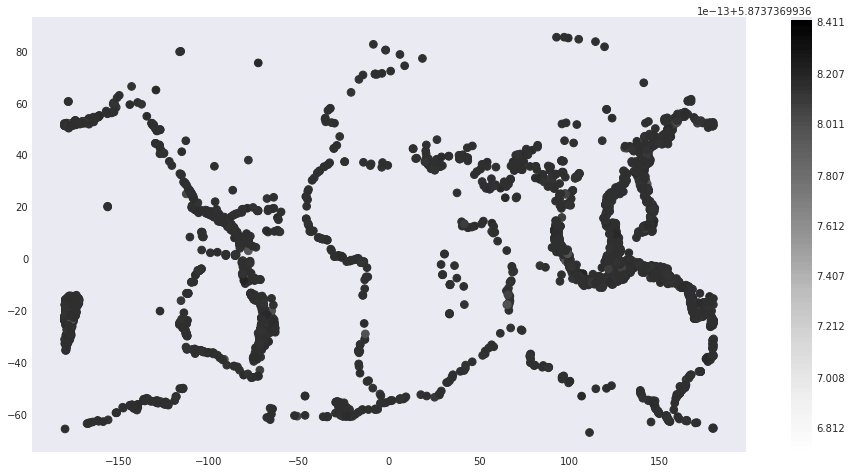

In [428]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df2.comp1,node_size = abs(_df2.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

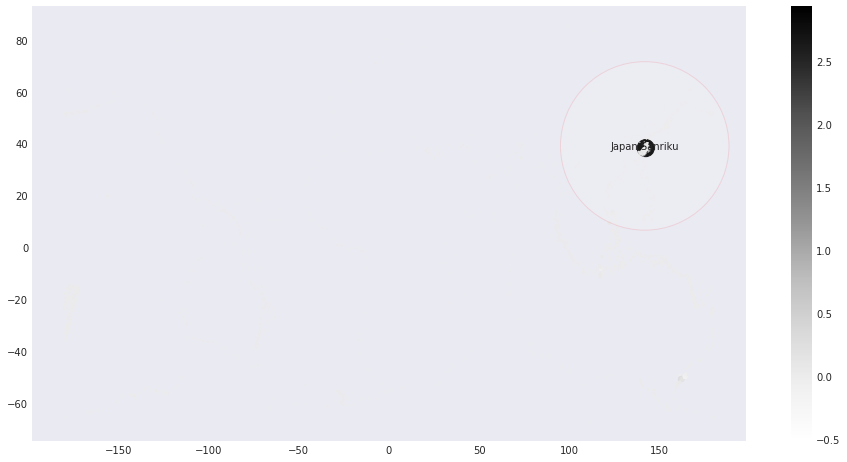

In [429]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df2.comp2,node_size = np.abs(_df2.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

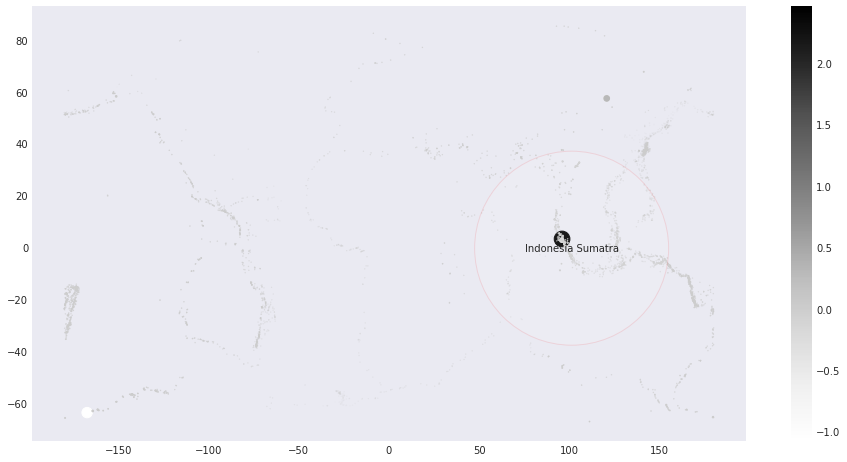

In [430]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df2.comp3,node_size = np.abs(_df2.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

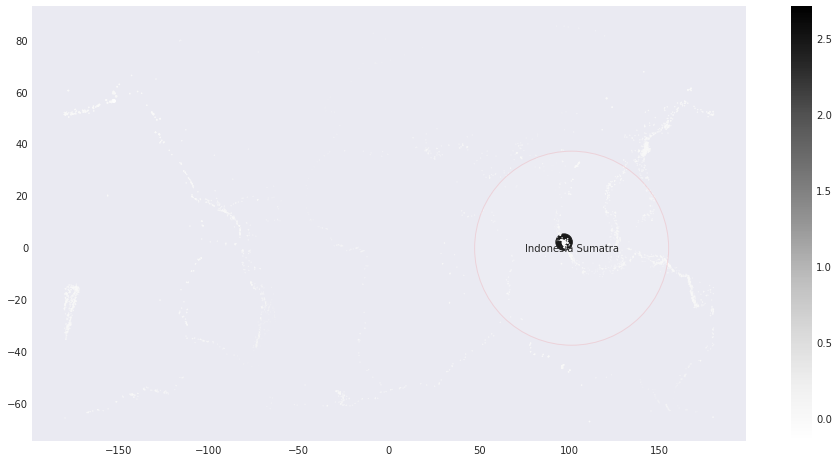

In [431]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df2.comp4,node_size = np.abs(_df2.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

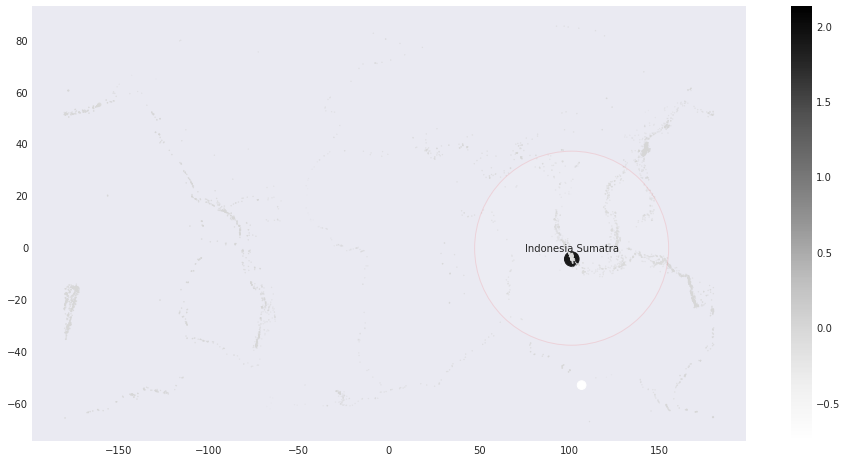

In [432]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df2.comp5,node_size = abs(_df2.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
    #               va="center", ha="center",
    #               bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$dist$를 이용한 $\theta$ = 100, $\kappa$ = 1000**

In [433]:
_G3 = nx.Graph(W3-np.identity(len(f)))

In [434]:
_pos3 = nx.spring_layout(_G3,iterations=20)

In [435]:
m_pos3 = list(zip(_df3.Longitude,_df3.Latitude))

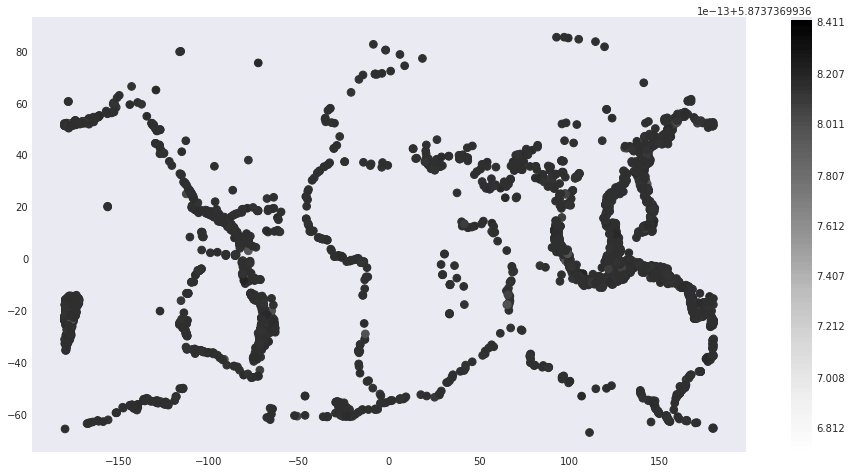

In [436]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df3.comp1,node_size = abs(_df3.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

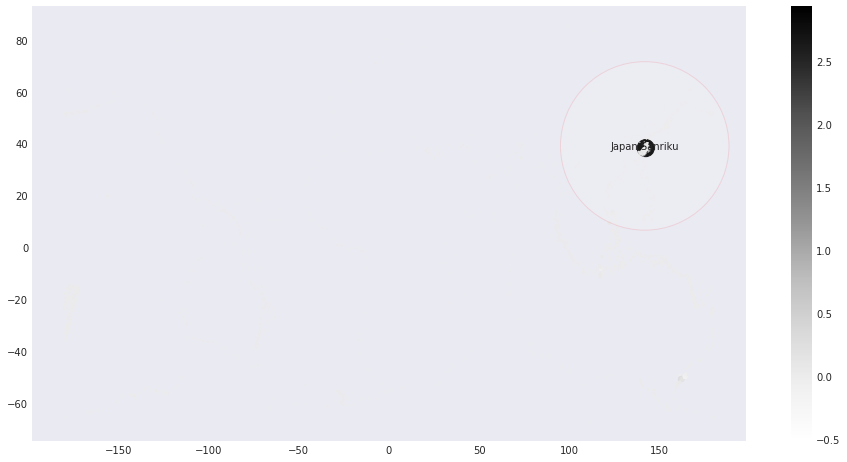

In [437]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df3.comp2,node_size = np.abs(_df3.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

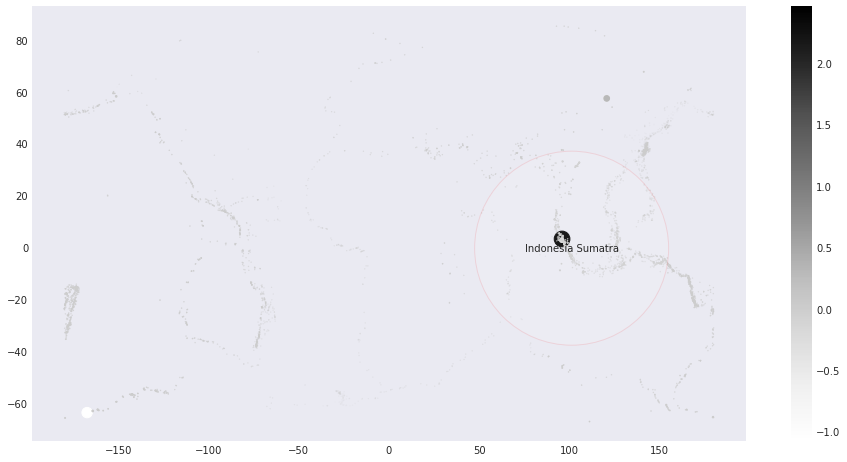

In [438]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df3.comp3,node_size = np.abs(_df3.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

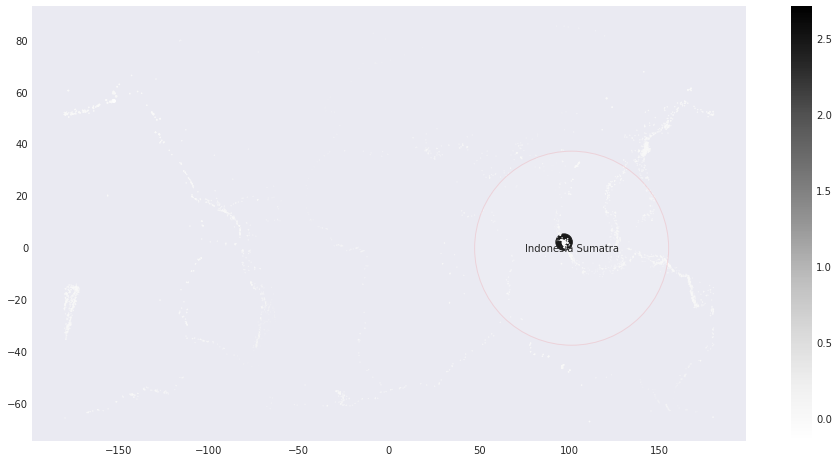

In [439]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df3.comp4,node_size = np.abs(_df3.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

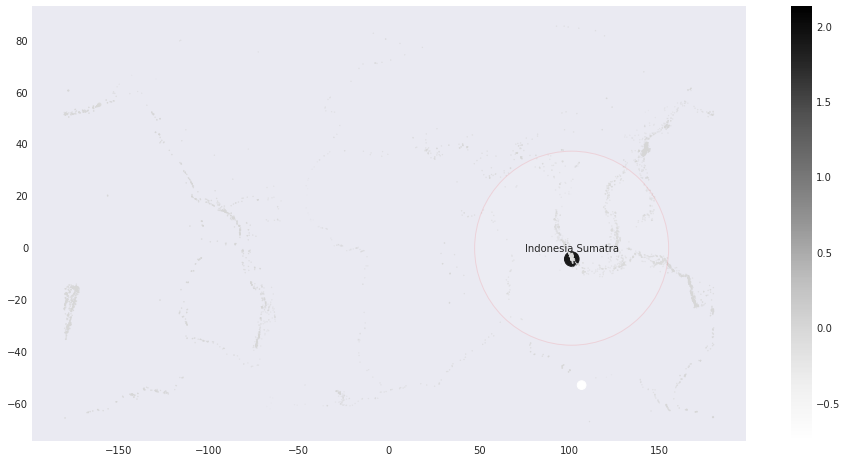

In [440]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df3.comp5,node_size = abs(_df3.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 50000,$\kappa$ = 100000**

In [441]:
_G4 = nx.Graph(W4-np.identity(len(f)))

In [442]:
_pos4 = nx.spring_layout(_G4,iterations=20)

In [443]:
m_pos4 = list(zip(_df4.Longitude,_df4.Latitude))

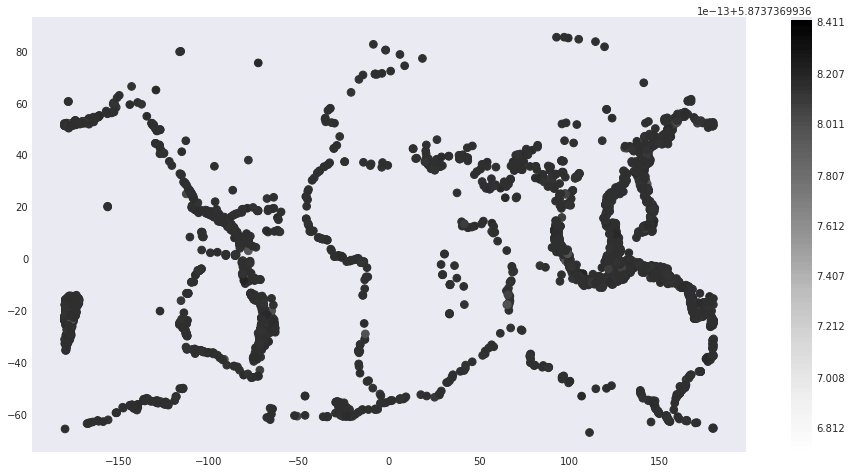

In [444]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df4.comp1,node_size = abs(_df4.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

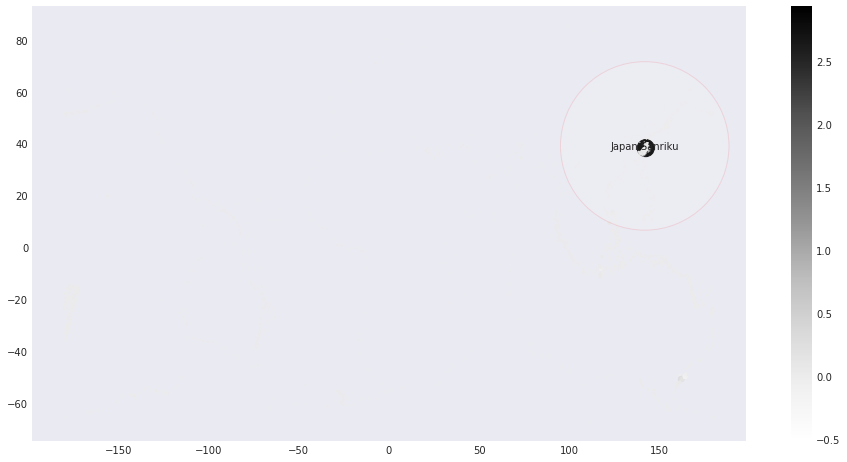

In [445]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df4.comp2,node_size = np.abs(_df4.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

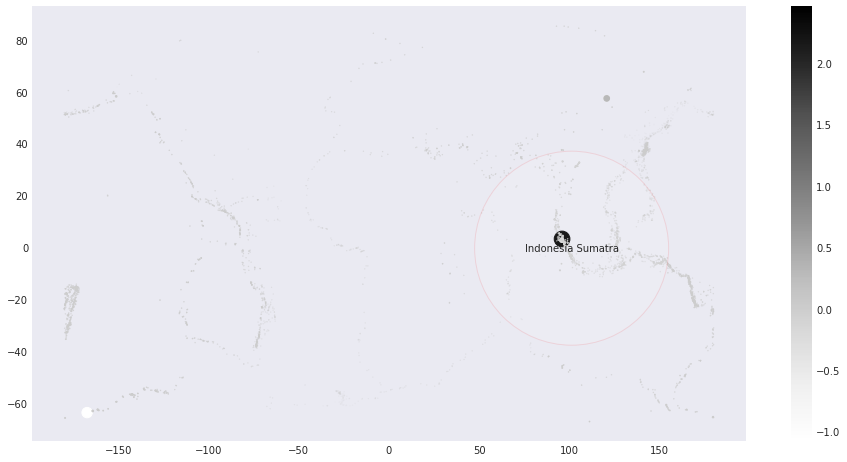

In [446]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df4.comp3,node_size = np.abs(_df4.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

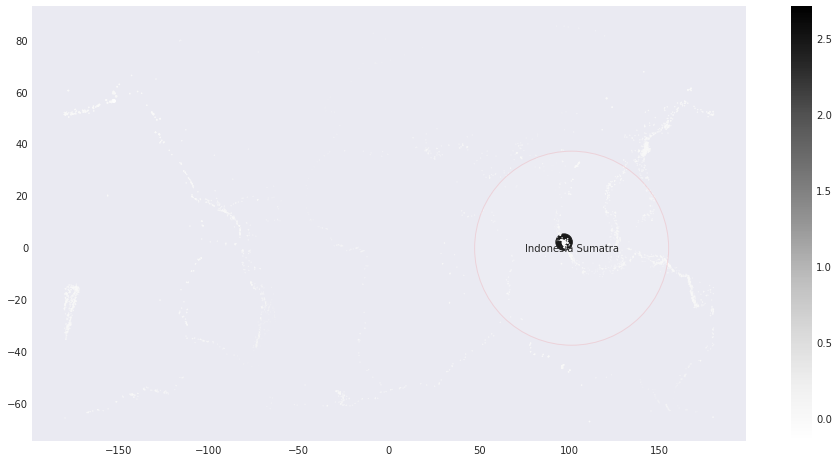

In [447]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df4.comp4,node_size = np.abs(_df4.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

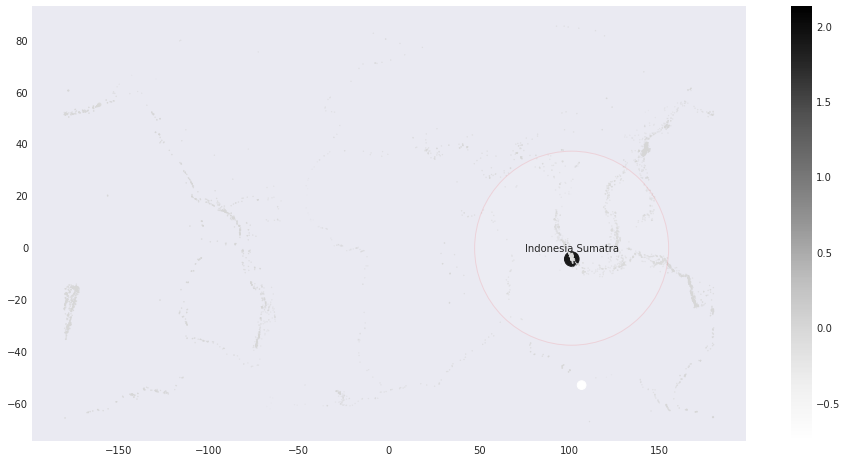

In [448]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df4.comp5,node_size = abs(_df4.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # ax.annotate("Tasman Sea", xy=(160.4313,-40.8581), xycoords="data",
    #               va="center", ha="center",
    #               bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 75000,$\kappa$ = 100000**

In [449]:
_G5 = nx.Graph(W5-np.identity(len(f)))

In [450]:
_pos5 = nx.spring_layout(_G5,iterations=20)

In [451]:
m_pos5 = list(zip(_df5.Longitude,_df5.Latitude))

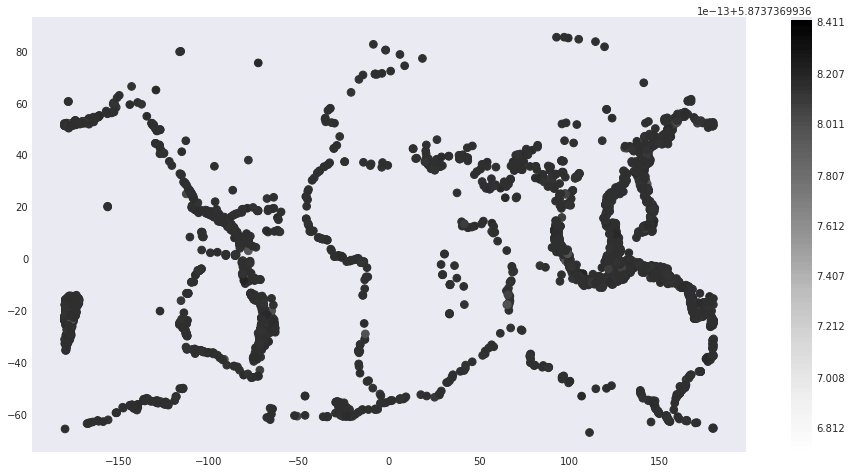

In [452]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df5.comp1,node_size = abs(_df5.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

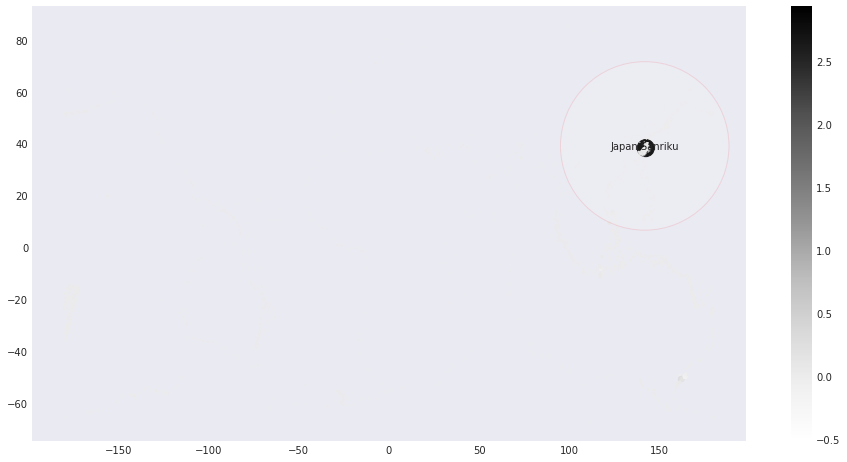

In [453]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df5.comp2,node_size = np.abs(_df5.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

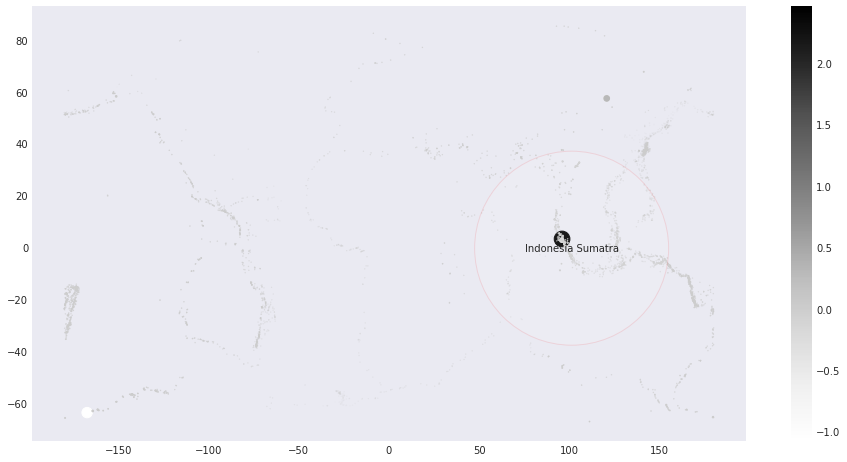

In [454]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df5.comp3,node_size = np.abs(_df5.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

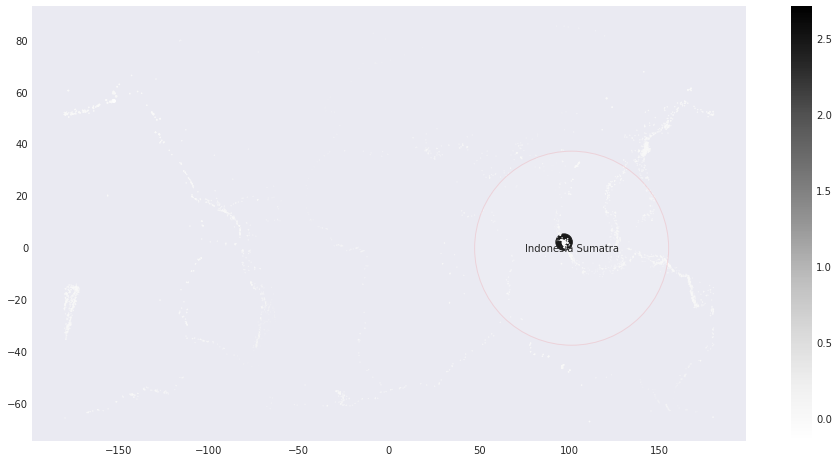

In [455]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df5.comp4,node_size = np.abs(_df5.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

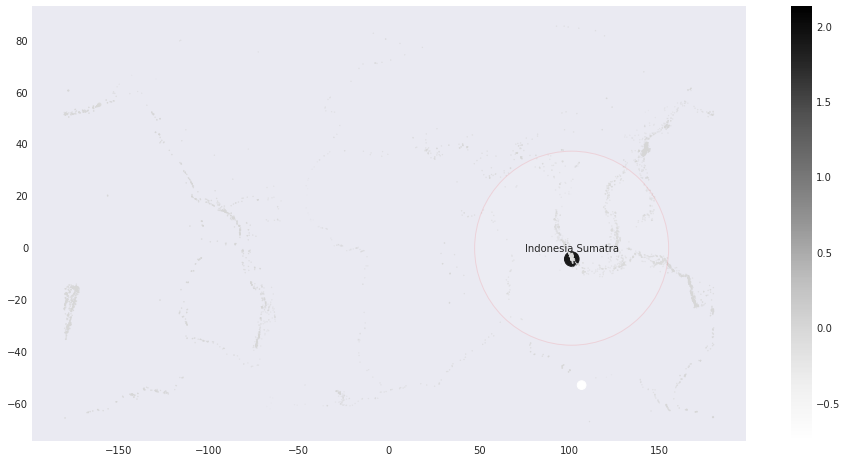

In [456]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df5.comp5,node_size = abs(_df5.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 100000,$\kappa$ = 100000**

In [457]:
_G6 = nx.Graph(W6-np.identity(len(f)))

In [458]:
_pos6 = nx.spring_layout(_G6,iterations=20)

In [459]:
m_pos6 = list(zip(_df6.Longitude,_df6.Latitude))

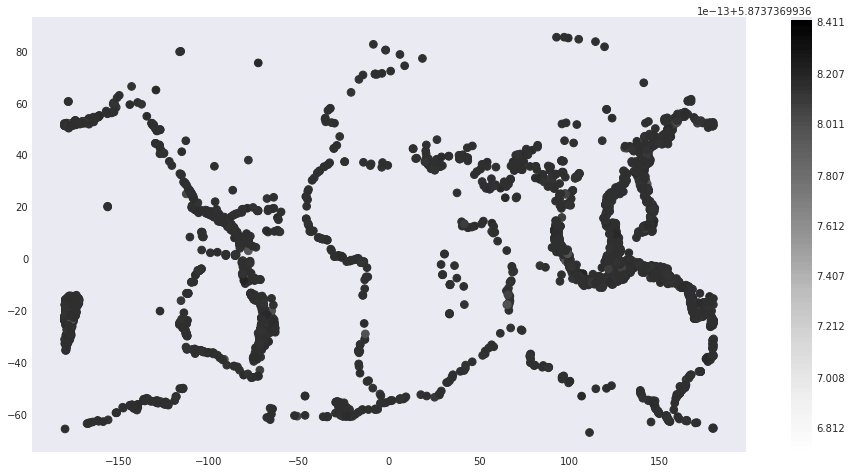

In [460]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df6.comp1,node_size = abs(_df6.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

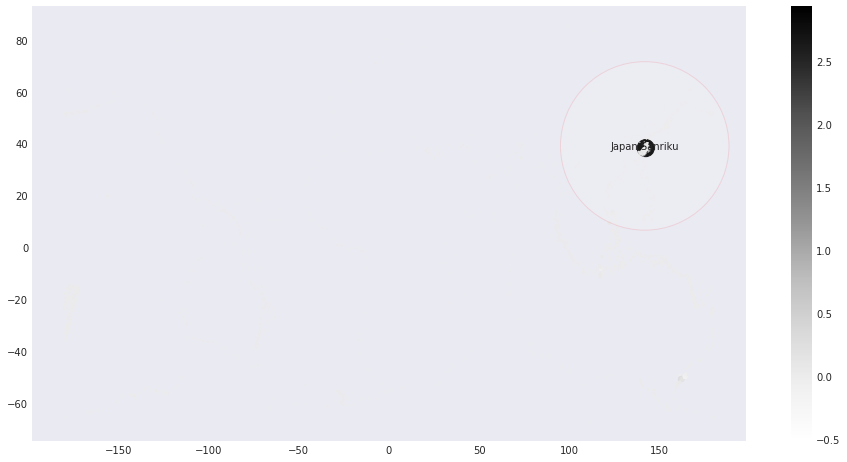

In [461]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df6.comp2,node_size = np.abs(_df6.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

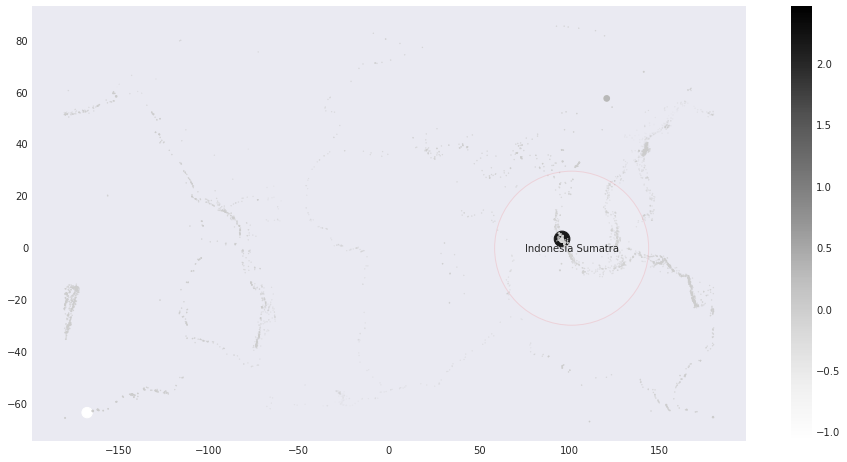

In [462]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df6.comp3,node_size = np.abs(_df6.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

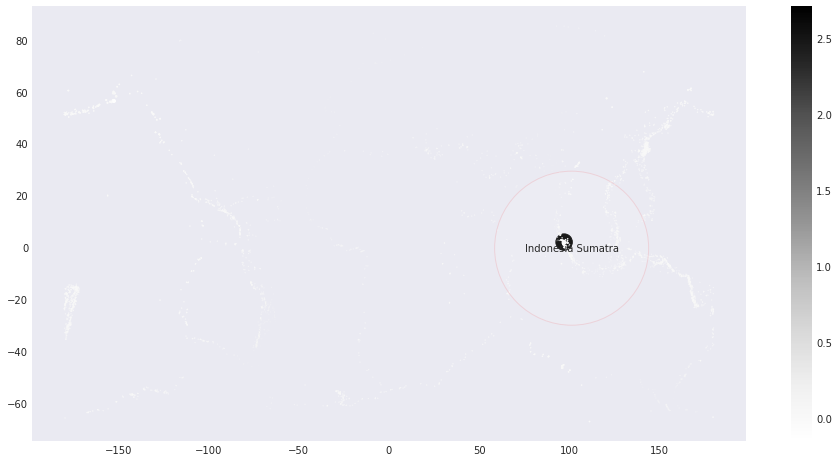

In [463]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df6.comp4,node_size = np.abs(_df6.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

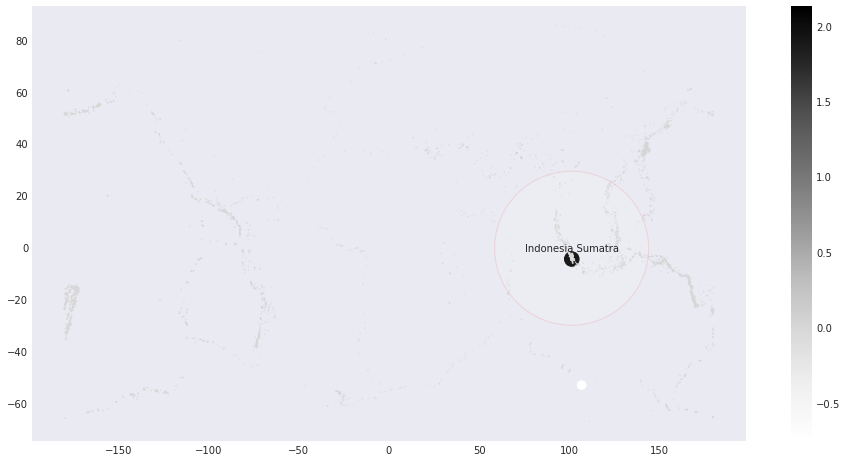

In [464]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df6.comp5,node_size = abs(_df6.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

#### Time 부여?

In [793]:
_df_1 = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2004"').reset_index().iloc[:,1:]

In [794]:
_df_2 = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2005"').reset_index().iloc[:,1:]

In [795]:
_df_3 = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2006"').reset_index().iloc[:,1:]

In [796]:
_df_4 = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2007"').reset_index().iloc[:,1:]

In [797]:
_df_5 = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2008"').reset_index().iloc[:,1:]

In [798]:
_df_6 = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2009"').reset_index().iloc[:,1:]

In [799]:
_df_7 = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2010"').reset_index().iloc[:,1:]

In [800]:
_df_8 = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2011"').reset_index().iloc[:,1:]

In [801]:
f_1 = _df_1.loc[:,"Magnitude"]

In [802]:
f_2 = _df_2.loc[:,"Magnitude"]

In [803]:
f_3 = _df_3.loc[:,"Magnitude"]

In [984]:
f_4 = _df_4.loc[:,"Magnitude"]

In [985]:
f_5 = _df_5.loc[:,"Magnitude"]

In [986]:
f_6 = _df_6.loc[:,"Magnitude"]

In [987]:
f_7 = _df_7.loc[:,"Magnitude"]

In [988]:
f_8 = _df_8.loc[:,"Magnitude"]

In [832]:
def dist_1(i,j):
    a1=abs(_df_1.Latitude[j] - _df_1.Latitude[i])
    a2=abs(_df_1.Latitude[j] + _df_1.Latitude[i])
    b1=abs(_df_1.Longitude[j] - _df_1.Longitude[i])
    b2=abs(_df_1.Longitude[j] + _df_1.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [833]:
def weight_1(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist_1(i,j))**2 / (2*theta**2) ) if dist_1(i,j) <= kappa else 0

In [834]:
def dist_2(i,j):
    a1=abs(_df_2.Latitude[j] - _df_2.Latitude[i])
    a2=abs(_df_2.Latitude[j] + _df_2.Latitude[i])
    b1=abs(_df_2.Longitude[j] - _df_2.Longitude[i])
    b2=abs(_df_2.Longitude[j] + _df_2.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [835]:
def weight_2(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist_2(i,j))**2 / (2*theta**2) ) if dist_2(i,j) <= kappa else 0

In [836]:
def dist_3(i,j):
    a1=abs(_df_3.Latitude[j] - _df_3.Latitude[i])
    a2=abs(_df_3.Latitude[j] + _df_3.Latitude[i])
    b1=abs(_df_3.Longitude[j] - _df_3.Longitude[i])
    b2=abs(_df_3.Longitude[j] + _df_3.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [837]:
def weight_3(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist_3(i,j))**2 / (2*theta**2) ) if dist_3(i,j) <= kappa else 0

In [815]:
def dist_4(i,j):
    a1=abs(_df_4.Latitude[j] - _df_4.Latitude[i])
    a2=abs(_df_4.Latitude[j] + _df_4.Latitude[i])
    b1=abs(_df_4.Longitude[j] - _df_4.Longitude[i])
    b2=abs(_df_4.Longitude[j] + _df_4.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [816]:
def weight_4(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist_4(i,j))**2 / (2*theta**2) ) if dist_4(i,j) <= kappa else 0

In [817]:
def dist_5(i,j):
    a1=abs(_df_5.Latitude[j] - _df_5.Latitude[i])
    a2=abs(_df_5.Latitude[j] + _df_5.Latitude[i])
    b1=abs(_df_5.Longitude[j] - _df_5.Longitude[i])
    b2=abs(_df_5.Longitude[j] + _df_5.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [818]:
def weight_5(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist_5(i,j))**2 / (2*theta**2) ) if dist_5(i,j) <= kappa else 0

In [819]:
def dist_6(i,j):
    a1=abs(_df_6.Latitude[j] - _df_6.Latitude[i])
    a2=abs(_df_6.Latitude[j] + _df_6.Latitude[i])
    b1=abs(_df_6.Longitude[j] - _df_6.Longitude[i])
    b2=abs(_df_6.Longitude[j] + _df_6.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [820]:
def weight_6(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist_6(i,j))**2 / (2*theta**2) ) if dist_6(i,j) <= kappa else 0

In [821]:
def dist_7(i,j):
    a1=abs(_df_7.Latitude[j] - _df_7.Latitude[i])
    a2=abs(_df_7.Latitude[j] + _df_7.Latitude[i])
    b1=abs(_df_7.Longitude[j] - _df_7.Longitude[i])
    b2=abs(_df_7.Longitude[j] + _df_7.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [822]:
def weight_7(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist_7(i,j))**2 / (2*theta**2) ) if dist_7(i,j) <= kappa else 0

In [823]:
def dist_8(i,j):
    a1=abs(_df_8.Latitude[j] - _df_8.Latitude[i])
    a2=abs(_df_8.Latitude[j] + _df_8.Latitude[i])
    b1=abs(_df_8.Longitude[j] - _df_8.Longitude[i])
    b2=abs(_df_8.Longitude[j] + _df_8.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [824]:
def weight_8(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist_8(i,j))**2 / (2*theta**2) ) if dist_8(i,j) <= kappa else 0

In [825]:
from haversine import haversine

In [826]:
def distdist_1(i,j):
    return haversine((_df_1.Latitude[i],_df_1.Longitude[i]),(_df_1.Latitude[j],_df_1.Longitude[j]))

In [827]:
def weightweight_1(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(distdist_1(i,j))**2 / (2*theta**2) ) if distdist_1(i,j) <= kappa else 0

In [828]:
def distdist_2(i,j):
    return haversine((_df_2.Latitude[i],_df_2.Longitude[i]),(_df_2.Latitude[j],_df_2.Longitude[j]))

In [829]:
def weightweight_2(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(distdist_2(i,j))**2 / (2*theta**2) ) if distdist_2(i,j) <= kappa else 0

In [830]:
def distdist_3(i,j):
    return haversine((_df_3.Latitude[i],_df_3.Longitude[i]),(_df_3.Latitude[j],_df_3.Longitude[j]))

In [831]:
def weightweight_3(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(distdist_3(i,j))**2 / (2*theta**2) ) if distdist_3(i,j) <= kappa else 0

In [838]:
def distdist_4(i,j):
    return haversine((_df_4.Latitude[i],_df_4.Longitude[i]),(_df_4.Latitude[j],_df_4.Longitude[j]))

In [839]:
def weightweight_4(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(distdist_4(i,j))**2 / (2*theta**2) ) if distdist_4(i,j) <= kappa else 0

In [840]:
def distdist_5(i,j):
    return haversine((_df_5.Latitude[i],_df_5.Longitude[i]),(_df_5.Latitude[j],_df_5.Longitude[j]))

In [841]:
def weightweight_5(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(distdist_5(i,j))**2 / (2*theta**2) ) if distdist_5(i,j) <= kappa else 0

In [842]:
def distdist_6(i,j):
    return haversine((_df_6.Latitude[i],_df_6.Longitude[i]),(_df_6.Latitude[j],_df_6.Longitude[j]))

In [843]:
def weightweight_6(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(distdist_6(i,j))**2 / (2*theta**2) ) if distdist_6(i,j) <= kappa else 0

In [844]:
def distdist_7(i,j):
    return haversine((_df_7.Latitude[i],_df_7.Longitude[i]),(_df_7.Latitude[j],_df_7.Longitude[j]))

In [846]:
def weightweight_8(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(distdist_8(i,j))**2 / (2*theta**2) ) if distdist_8(i,j) <= kappa else 0

In [847]:
def distdist_8(i,j):
    return haversine((_df_8.Latitude[i],_df_8.Longitude[i]),(_df_8.Latitude[j],_df_8.Longitude[j]))

In [831]:
def weightweight_3(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(distdist_3(i,j))**2 / (2*theta**2) ) if distdist_3(i,j) <= kappa else 0

In [1032]:
_df

,Date,Latitude,Longitude,Magnitude,Year,comp1,comp2,comp3,comp4,comp5
0,01/01/2004,-21.476,169.859,5.5,2004,5.873737,0.000208,0.002676,0.000136,-3.035466e-05
1,01/01/2004,-8.310,115.788,5.8,2004,5.873737,-0.000099,-0.000349,-0.000156,2.433649e-04
2,01/01/2004,17.488,-101.303,6.1,2004,5.873737,-0.000372,-0.000578,-0.000586,-8.779897e-04
3,01/01/2004,17.420,-101.315,5.7,2004,5.873737,-0.000371,-0.000579,-0.000584,-8.728688e-04
4,01/03/2004,-22.376,169.728,6.0,2004,5.873737,0.000229,0.002517,0.000166,-3.045287e-05
...,...,...,...,...,...,...,...,...,...,...
4512,12/23/2011,-52.120,27.958,5.9,2011,5.873737,0.000086,0.000175,0.000108,-6.799983e-07
4513,12/26/2011,-16.198,-173.862,6.0,2011,5.873737,0.000096,-0.004896,-0.000026,-2.173984e-05
4514,12/26/2011,-19.168,168.704,5.5,2011,5.873737,0.000268,0.001995,0.000111,-3.038715e-05
4515,12/27/2011,51.842,95.911,6.6,2011,5.873737,0.001654,-0.001908,0.002296,-2.541818e-05


In [1039]:
def beta_1(i,j,beta=2):
    if _df.Year[i] == _df.Year[j]:
        return 1
    elif abs(int(_df.Year[i]) - int(_df.Year[j])) == 1:
        return beta
    else:
        return 0

In [1040]:
_beta = np.array([[beta_1(i,j) for i in  range(len(_df))] for j in range(len(_df))])

In [1041]:
_beta

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [848]:
W_11 = np.array([[weight_1(i,j) for i in range(len(_df_1))] for j in range(len(_df_1))])

In [849]:
W_21 = np.array([[weight_2(i,j) for i in range(len(_df_2))] for j in range(len(_df_2))])

In [850]:
W_31 = np.array([[weight_3(i,j) for i in range(len(_df_3))] for j in range(len(_df_3))])

In [854]:
W_41 = np.array([[weight_4(i,j) for i in range(len(_df_4))] for j in range(len(_df_4))])

In [855]:
W_51 = np.array([[weight_5(i,j) for i in range(len(_df_5))] for j in range(len(_df_5))])

In [856]:
W_61 = np.array([[weight_6(i,j) for i in range(len(_df_6))] for j in range(len(_df_6))])

In [857]:
W_71 = np.array([[weight_7(i,j) for i in range(len(_df_7))] for j in range(len(_df_7))])

In [858]:
W_81 = np.array([[weight_8(i,j) for i in range(len(_df_8))] for j in range(len(_df_8))])

In [851]:
W_12 = np.array([[weightweight_1(i,j) for i in range(len(_df_1))] for j in range(len(_df_1))])

In [852]:
W_22 = np.array([[weightweight_2(i,j) for i in range(len(_df_2))] for j in range(len(_df_2))])

In [853]:
W_32 = np.array([[weightweight_3(i,j) for i in range(len(_df_3))] for j in range(len(_df_3))])

In [859]:
W_42 = np.array([[weightweight_4(i,j) for i in range(len(_df_4))] for j in range(len(_df_4))])

In [860]:
W_52 = np.array([[weightweight_5(i,j) for i in range(len(_df_5))] for j in range(len(_df_5))])

In [861]:
W_62 = np.array([[weightweight_6(i,j) for i in range(len(_df_6))] for j in range(len(_df_6))])

In [862]:
W_72 = np.array([[weightweight_7(i,j) for i in range(len(_df_7))] for j in range(len(_df_7))])

In [863]:
W_82 = np.array([[weightweight_8(i,j) for i in range(len(_df_8))] for j in range(len(_df_8))])

In [864]:
D_11 = np.diag(W_11.sum(axis=1))

In [865]:
D_21 = np.diag(W_21.sum(axis=1))

In [866]:
D_31 = np.diag(W_31.sum(axis=1))

In [870]:
D_41 = np.diag(W_41.sum(axis=1))

In [871]:
D_51 = np.diag(W_51.sum(axis=1))

In [872]:
D_61 = np.diag(W_61.sum(axis=1))

In [873]:
D_71 = np.diag(W_71.sum(axis=1))

In [874]:
D_81 = np.diag(W_81.sum(axis=1))

In [867]:
D_12 = np.diag(W_12.sum(axis=1))

In [868]:
D_22 = np.diag(W_22.sum(axis=1))

In [869]:
D_32 = np.diag(W_32.sum(axis=1))

In [875]:
D_42 = np.diag(W_42.sum(axis=1))

In [876]:
D_52 = np.diag(W_52.sum(axis=1))

In [877]:
D_62 = np.diag(W_62.sum(axis=1))

In [878]:
D_72 = np.diag(W_72.sum(axis=1))

In [879]:
D_82 = np.diag(W_82.sum(axis=1))

In [880]:
L_11 = D_11 - W_11

In [881]:
L_21 = D_21 - W_21

In [882]:
L_31 = D_31 - W_31

In [886]:
L_41 = D_41 - W_41

In [887]:
L_51 = D_51 - W_51

In [888]:
L_61 = D_61 - W_61

In [889]:
L_71 = D_71 - W_71

In [890]:
L_81 = D_81 - W_81

In [883]:
L_12 = D_12 - W_12

In [884]:
L_22 = D_22 - W_22

In [885]:
L_32 = D_32 - W_32

In [891]:
L_42 = D_42 - W_42

In [892]:
L_52 = D_52 - W_52

In [893]:
L_62 = D_62 - W_62

In [894]:
L_72 = D_72 - W_72

In [895]:
L_82 = D_82 - W_82

In [896]:
λ_11, Ψ_11 = np.linalg.eig(L_11)

In [897]:
Λ_11 = np.diag(λ_11)

In [898]:
λ_21, Ψ_21 = np.linalg.eig(L_21)

In [899]:
Λ_21 = np.diag(λ_21)

In [900]:
λ_31, Ψ_31 = np.linalg.eig(L_31)

In [901]:
Λ_31 = np.diag(λ_31)

In [908]:
λ_41, Ψ_41 = np.linalg.eig(L_41)

In [909]:
Λ_41 = np.diag(λ_41)

In [910]:
λ_51, Ψ_51 = np.linalg.eig(L_51)

In [911]:
Λ_51 = np.diag(λ_51)

In [912]:
λ_61, Ψ_61 = np.linalg.eig(L_61)

In [913]:
Λ_61 = np.diag(λ_61)

In [914]:
λ_71, Ψ_71 = np.linalg.eig(L_71)

In [915]:
Λ_71 = np.diag(λ_71)

In [916]:
λ_81, Ψ_81 = np.linalg.eig(L_81)

In [917]:
Λ_81 = np.diag(λ_81)

In [918]:
λ_12, Ψ_12 = np.linalg.eig(L_12)

In [919]:
Λ_12 = np.diag(λ_12)

In [920]:
λ_22, Ψ_22 = np.linalg.eig(L_22)

In [921]:
Λ_22 = np.diag(λ_22)

In [922]:
λ_32, Ψ_32 = np.linalg.eig(L_32)

In [923]:
Λ_32 = np.diag(λ_32)

In [924]:
λ_42, Ψ_42 = np.linalg.eig(L_42)

In [925]:
Λ_42 = np.diag(λ_42)

In [926]:
λ_52, Ψ_52 = np.linalg.eig(L_52)

In [927]:
Λ_52 = np.diag(λ_52)

In [928]:
λ_62, Ψ_62 = np.linalg.eig(L_62)

In [929]:
Λ_62 = np.diag(λ_62)

In [930]:
λ_72, Ψ_72 = np.linalg.eig(L_72)

In [931]:
Λ_72 = np.diag(λ_72)

In [932]:
λ_82, Ψ_82 = np.linalg.eig(L_82)

In [933]:
Λ_82 = np.diag(λ_82)

In [934]:
def comp_11(i):
    return (f_1 @ np.outer( Ψ_11[:,i], Ψ_11[:,i]))

In [935]:
def p_11(i):
    return sum(comp_11(i)**2)

In [936]:
def comp_21(i):
    return (f_2 @ np.outer( Ψ_21[:,i], Ψ_21[:,i]))

In [937]:
def p_21(i):
    return sum(comp_21(i)**2)

In [938]:
def comp_31(i):
    return (f_3 @ np.outer( Ψ_31[:,i], Ψ_31[:,i]))

In [983]:
def p_31(i):
    return sum(comp_31(i)**2)

In [980]:
def comp_41(i):
    return (f_4 @ np.outer( Ψ_41[:,i], Ψ_41[:,i]))

In [981]:
def p_41(i):
    return sum(comp_41(i)**2)

In [949]:
def comp_51(i):
    return (f_5 @ np.outer( Ψ_51[:,i], Ψ_51[:,i]))

In [948]:
def p_51(i):
    return sum(comp_51(i)**2)

In [951]:
def comp_61(i):
    return (f_6 @ np.outer( Ψ_61[:,i], Ψ_61[:,i]))

In [950]:
def p_61(i):
    return sum(comp_61(i)**2)

In [953]:
def comp_71(i):
    return (f_7 @ np.outer( Ψ_71[:,i], Ψ_71[:,i]))

In [952]:
def p_71(i):
    return sum(comp_71(i)**2)

In [955]:
def comp_81(i):
    return (f_8 @ np.outer( Ψ_81[:,i], Ψ_81[:,i]))

In [956]:
def p_81(i):
    return sum(comp_81(i)**2)

In [940]:
def comp_12(i):
    return (f_1 @ np.outer( Ψ_12[:,i], Ψ_12[:,i]))

In [941]:
def p_12(i):
    return sum(comp_12(i)**2)

In [942]:
def comp_22(i):
    return (f_2 @ np.outer( Ψ_22[:,i], Ψ_22[:,i]))

In [943]:
def p_22(i):
    return sum(comp_22(i)**2)

In [944]:
def comp_32(i):
    return (f_3 @ np.outer( Ψ_32[:,i], Ψ_32[:,i]))

In [945]:
def p_32(i):
    return sum(comp_32(i)**2)

In [957]:
def comp_42(i):
    return (f_4 @ np.outer( Ψ_42[:,i], Ψ_42[:,i]))

In [958]:
def p_42(i):
    return sum(comp_42(i)**2)

In [959]:
def comp_52(i):
    return (f_5 @ np.outer( Ψ_52[:,i], Ψ_52[:,i]))

In [960]:
def p_52(i):
    return sum(comp_52(i)**2)

In [961]:
def comp_62(i):
    return (f_6 @ np.outer( Ψ_62[:,i], Ψ_62[:,i]))

In [962]:
def p_62(i):
    return sum(comp_62(i)**2)

In [963]:
def comp_72(i):
    return (f_7 @ np.outer( Ψ_72[:,i], Ψ_72[:,i]))

In [964]:
def p_72(i):
    return sum(comp_72(i)**2)

In [965]:
def comp_82(i):
    return (f_8 @ np.outer( Ψ_82[:,i], Ψ_82[:,i]))

In [966]:
def p_82(i):
    return sum(comp_82(i)**2)

In [967]:
array_111 = np.array([p_11(i) for i in range(1,len(_df_1))])

In [968]:
array_121 = np.array([p_21(i) for i in range(1,len(_df_2))])

In [969]:
array_131 = np.array([p_31(i) for i in range(1,len(_df_3))])

In [989]:
array_141 = np.array([p_41(i) for i in range(1,len(_df_4))])

In [990]:
array_151 = np.array([p_51(i) for i in range(1,len(_df_5))])

In [991]:
array_161 = np.array([p_61(i) for i in range(1,len(_df_6))])

In [992]:
array_171 = np.array([p_71(i) for i in range(1,len(_df_7))])

In [993]:
array_181 = np.array([p_81(i) for i in range(1,len(_df_8))])

In [970]:
array_112 = np.array([p_12(i) for i in range(1,len(_df_1))])

In [971]:
array_122 = np.array([p_22(i) for i in range(1,len(_df_2))])

In [972]:
array_132 = np.array([p_32(i) for i in range(1,len(_df_3))])

In [994]:
array_142 = np.array([p_42(i) for i in range(1,len(_df_4))])

In [995]:
array_152 = np.array([p_52(i) for i in range(1,len(_df_5))])

In [996]:
array_162 = np.array([p_62(i) for i in range(1,len(_df_6))])

In [997]:
array_172 = np.array([p_72(i) for i in range(1,len(_df_7))])

In [998]:
array_182 = np.array([p_82(i) for i in range(1,len(_df_8))])

In [999]:
varprop_11 = array_111/array_111.sum()

In [1000]:
varprop_21 = array_121/array_121.sum()

In [1001]:
varprop_31 = array_131/array_131.sum()

In [1005]:
varprop_41 = array_141/array_141.sum()

In [1006]:
varprop_51 = array_151/array_151.sum()

In [1007]:
varprop_61 = array_161/array_161.sum()

In [1008]:
varprop_71 = array_171/array_171.sum()

In [1009]:
varprop_81 = array_181/array_181.sum()

In [1002]:
varprop_12 = array_112/array_112.sum()

In [1003]:
varprop_22 = array_122/array_122.sum()

In [1004]:
varprop_32 = array_132/array_132.sum()

In [1010]:
varprop_42 = array_142/array_142.sum()

In [1011]:
varprop_52 = array_152/array_152.sum()

In [1012]:
varprop_62 = array_162/array_162.sum()

In [1013]:
varprop_72 = array_172/array_172.sum()

In [1014]:
varprop_82 = array_182/array_182.sum()

In [538]:
#collapse
_index_11 = pd.DataFrame({'index':range(1,len(_df_1)),'varprop':varprop_11}).sort_values('varprop',ascending=False)
_indexlst_11 = _index_11.iloc[:25,0].tolist()

In [539]:
#collapse
_index_21 = pd.DataFrame({'index':range(1,len(_df_2)),'varprop':varprop_21}).sort_values('varprop',ascending=False)
_indexlst_21 = _index_21.iloc[:25,0].tolist()

In [540]:
#collapse
_index_31 = pd.DataFrame({'index':range(1,len(_df_3)),'varprop':varprop_31}).sort_values('varprop',ascending=False)
_indexlst_31 = _index_31.iloc[:25,0].tolist()

In [541]:
#collapse
_index_12 = pd.DataFrame({'index':range(1,len(_df_1)),'varprop':varprop_12}).sort_values('varprop',ascending=False)
_indexlst_12 = _index_12.iloc[:25,0].tolist()

In [542]:
#collapse
_index_22 = pd.DataFrame({'index':range(1,len(_df_2)),'varprop':varprop_22}).sort_values('varprop',ascending=False)
_indexlst_22 = _index_22.iloc[:25,0].tolist()

In [543]:
#collapse
_index_32 = pd.DataFrame({'index':range(1,len(_df_3)),'varprop':varprop_32}).sort_values('varprop',ascending=False)
_indexlst_32 = _index_32.iloc[:25,0].tolist()

In [629]:
comp1_11 = f_1 @ np.outer( Ψ_11[:,0], Ψ_11[:,0])

In [630]:
comp2_11 = f_1 @ np.outer( Ψ_11[:,_indexlst_11[0]], Ψ_11[:,_indexlst_11[0]])

In [631]:
comp3_11 = f_1 @ np.outer( Ψ_11[:,_indexlst_11[1]], Ψ_11[:,_indexlst_11[1]])

In [632]:
comp4_11 = f_1 @ np.outer( Ψ_11[:,_indexlst_11[2]], Ψ_11[:,_indexlst_11[2]])

In [633]:
comp5_11 = f_1 @ np.outer( Ψ_11[:,_indexlst_11[3]], Ψ_11[:,_indexlst_11[3]])

In [634]:
_df_1["comp1"] = comp1_11

In [635]:
_df_1["comp2"] = comp2_11

In [636]:
_df_1["comp3"] = comp3_11

In [637]:
_df_1["comp4"] = comp4_11

In [638]:
_df_1["comp5"] = comp5_11

In [544]:
comp1_12 = f_1 @ np.outer( Ψ_12[:,0], Ψ_12[:,0])

In [545]:
comp2_12 = f_1 @ np.outer( Ψ_12[:,_indexlst_12[0]], Ψ_12[:,_indexlst_12[0]])

In [546]:
comp3_12 = f_1 @ np.outer( Ψ_12[:,_indexlst_12[1]], Ψ_12[:,_indexlst_12[1]])

In [547]:
comp4_12 = f_1 @ np.outer( Ψ_12[:,_indexlst_12[2]], Ψ_12[:,_indexlst_12[2]])

In [548]:
comp5_12 = f_1 @ np.outer( Ψ_12[:,_indexlst_12[3]], Ψ_12[:,_indexlst_12[3]])

In [549]:
_df_1["comp11"] = comp1_12

In [550]:
_df_1["comp22"] = comp2_12

In [551]:
_df_1["comp33"] = comp3_12

In [552]:
_df_1["comp44"] = comp4_12

In [553]:
_df_1["comp55"] = comp5_12

In [554]:
comp1_21 = f_2 @ np.outer( Ψ_21[:,0], Ψ_21[:,0])

In [555]:
comp2_21 = f_2 @ np.outer( Ψ_21[:,_indexlst_21[0]], Ψ_21[:,_indexlst_21[0]])

In [556]:
comp3_21 = f_2 @ np.outer( Ψ_21[:,_indexlst_21[1]], Ψ_21[:,_indexlst_21[1]])

In [557]:
comp4_21 = f_2 @ np.outer( Ψ_21[:,_indexlst_21[2]], Ψ_21[:,_indexlst_21[2]])

In [558]:
comp5_21 = f_2 @ np.outer( Ψ_21[:,_indexlst_21[3]], Ψ_21[:,_indexlst_21[3]])

In [559]:
_df_2["comp1"] = comp1_21

In [560]:
_df_2["comp2"] = comp2_21

In [561]:
_df_2["comp3"] = comp3_21

In [581]:
_df_2["comp4"] = comp4_21

In [582]:
_df_2["comp5"] = comp5_21

In [583]:
comp1_31 = f_3 @ np.outer( Ψ_31[:,0], Ψ_31[:,0])

In [584]:
comp2_31 = f_3 @ np.outer( Ψ_31[:,_indexlst_31[0]], Ψ_31[:,_indexlst_31[0]])

In [585]:
comp3_31 = f_3 @ np.outer( Ψ_31[:,_indexlst_31[1]], Ψ_31[:,_indexlst_31[1]])

In [586]:
comp4_31 = f_3 @ np.outer( Ψ_31[:,_indexlst_31[2]], Ψ_31[:,_indexlst_31[2]])

In [587]:
comp5_31 = f_3 @ np.outer( Ψ_31[:,_indexlst_31[3]], Ψ_31[:,_indexlst_31[3]])

In [588]:
_df_3["comp1"] = comp1_31

In [589]:
_df_3["comp2"] = comp2_31

In [590]:
_df_3["comp3"] = comp3_31

In [591]:
_df_3["comp4"] = comp4_31

In [592]:
_df_3["comp5"] = comp5_31

In [593]:
comp1_12 = f_1 @ np.outer( Ψ_12[:,0], Ψ_12[:,0])

In [594]:
comp2_12 = f_1 @ np.outer( Ψ_12[:,_indexlst_12[0]], Ψ_12[:,_indexlst_12[0]])

In [595]:
comp3_12 = f_1 @ np.outer( Ψ_12[:,_indexlst_12[1]], Ψ_12[:,_indexlst_12[1]])

In [596]:
comp4_12 = f_1 @ np.outer( Ψ_12[:,_indexlst_12[2]], Ψ_12[:,_indexlst_12[2]])

In [597]:
comp5_12 = f_1 @ np.outer( Ψ_12[:,_indexlst_12[3]], Ψ_12[:,_indexlst_12[3]])

In [598]:
_df_1["comp11"] = comp1_12

In [599]:
_df_1["comp22"] = comp2_12

In [600]:
_df_1["comp33"] = comp3_12

In [601]:
_df_1["comp44"] = comp4_12

In [602]:
_df_1["comp55"] = comp5_12

In [603]:
comp1_22 = f_2 @ np.outer( Ψ_22[:,0], Ψ_22[:,0])

In [604]:
comp2_22 = f_2 @ np.outer( Ψ_22[:,_indexlst_22[0]], Ψ_22[:,_indexlst_22[0]])

In [605]:
comp3_22 = f_2 @ np.outer( Ψ_22[:,_indexlst_22[1]], Ψ_22[:,_indexlst_22[1]])

In [606]:
comp4_22 = f_2 @ np.outer( Ψ_22[:,_indexlst_22[2]], Ψ_22[:,_indexlst_22[2]])

In [607]:
comp5_22 = f_2 @ np.outer( Ψ_22[:,_indexlst_22[3]], Ψ_22[:,_indexlst_22[3]])

In [608]:
_df_2["comp11"] = comp1_22

In [609]:
_df_2["comp22"] = comp2_22

In [610]:
_df_2["comp33"] = comp3_22

In [611]:
_df_2["comp44"] = comp4_22

In [612]:
_df_2["comp55"] = comp5_22

In [613]:
comp1_32 = f_3 @ np.outer( Ψ_32[:,0], Ψ_32[:,0])

In [614]:
comp2_32 = f_3 @ np.outer( Ψ_32[:,_indexlst_32[0]], Ψ_32[:,_indexlst_32[0]])

In [615]:
comp3_32 = f_3 @ np.outer( Ψ_32[:,_indexlst_32[1]], Ψ_32[:,_indexlst_32[1]])

In [616]:
comp4_32 = f_3 @ np.outer( Ψ_32[:,_indexlst_32[2]], Ψ_32[:,_indexlst_32[2]])

In [617]:
comp5_32 = f_3 @ np.outer( Ψ_32[:,_indexlst_32[3]], Ψ_32[:,_indexlst_32[3]])

In [618]:
_df_3["comp11"] = comp1_32

In [619]:
_df_3["comp22"] = comp2_32

In [620]:
_df_3["comp33"] = comp3_32

In [621]:
_df_3["comp44"] = comp4_32

In [622]:
_df_3["comp55"] = comp5_32

In [623]:
pd.read_html('https://ko.wikipedia.org/wiki/%EC%A7%80%EC%A7%84_%EB%AA%A9%EB%A1%9D',encoding='utf-8')[1].iloc[[2,3,8],:]

,순위,일자,장소,이름,규모
2,3,2004년 12월 26일,인도네시아 수마트라섬,2004년 인도양 지진 해일,9.1-9.3
3,4,2011년 3월 11일,일본 산리쿠 해역,2011년 도호쿠 지방 태평양 앞바다 지진,9.1
8,6 (공동),2010년 2월 27일,칠레 마울레주 해역,2010년 칠레 지진,8.8


##### **$dist$를 이용한 2004년 $\theta$ = 80, $\kappa$ = 1000**

In [639]:
_G_11 = nx.Graph(W_11-np.identity(len(f_1)))

In [640]:
_pos_11 = nx.spring_layout(_G_11,iterations=20)

In [641]:
m_pos_11 = list(zip(_df_1.Longitude,_df_1.Latitude))

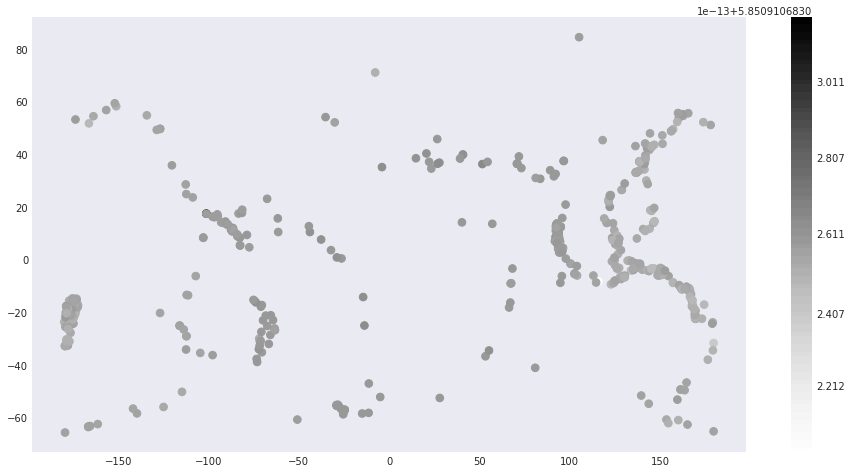

In [642]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_11,m_pos_11,node_color=_df_1.comp1,node_size = abs(_df_1.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

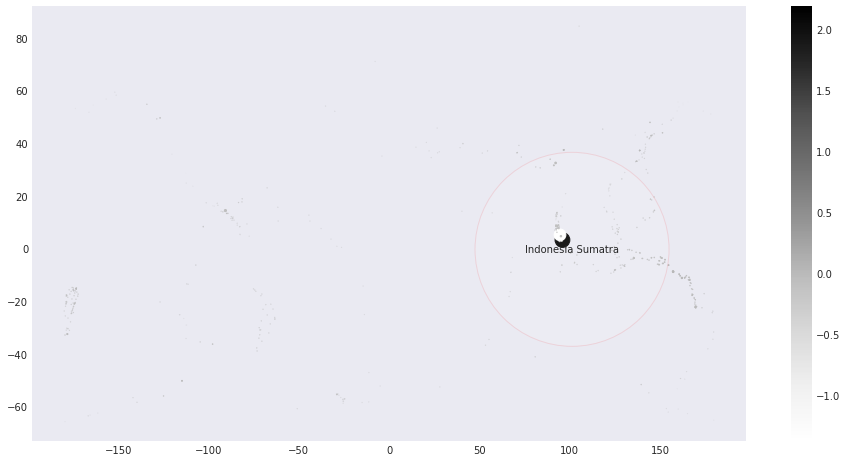

In [643]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_11,m_pos_11,node_color=_df_1.comp2,node_size = np.abs(_df_1.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

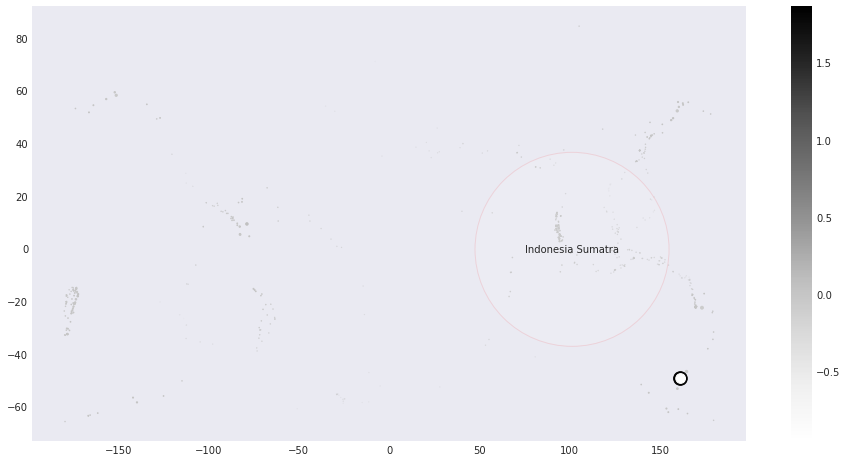

In [644]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_11,m_pos_11,node_color=_df_1.comp3,node_size = np.abs(_df_1.comp3)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

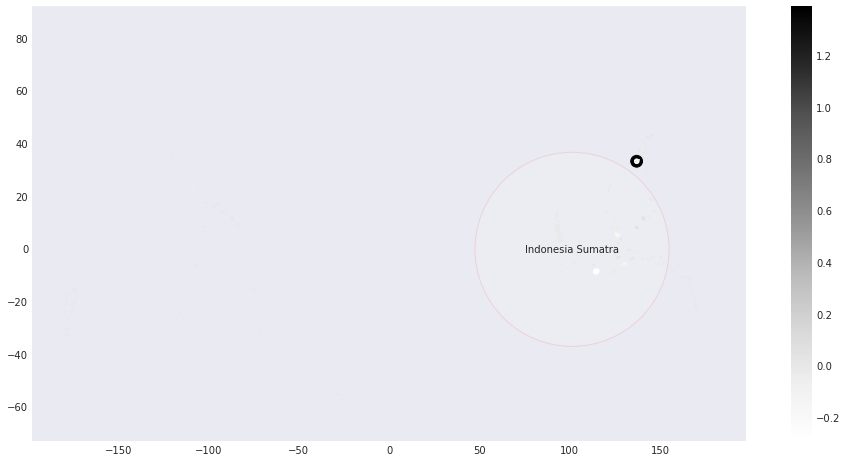

In [645]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_11,m_pos_11,node_color=_df_1.comp4,node_size = np.abs(_df_1.comp4)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

##### **$haversine$ 패키지를 이용한 2004년 $\theta$ = 100000,$\kappa$ = 100000**

In [646]:
_G_12 = nx.Graph(W_12-np.identity(len(f_1)))

In [647]:
_pos_12 = nx.spring_layout(_G_12,iterations=20)

In [648]:
m_pos_12 = list(zip(_df_1.Longitude,_df_1.Latitude))

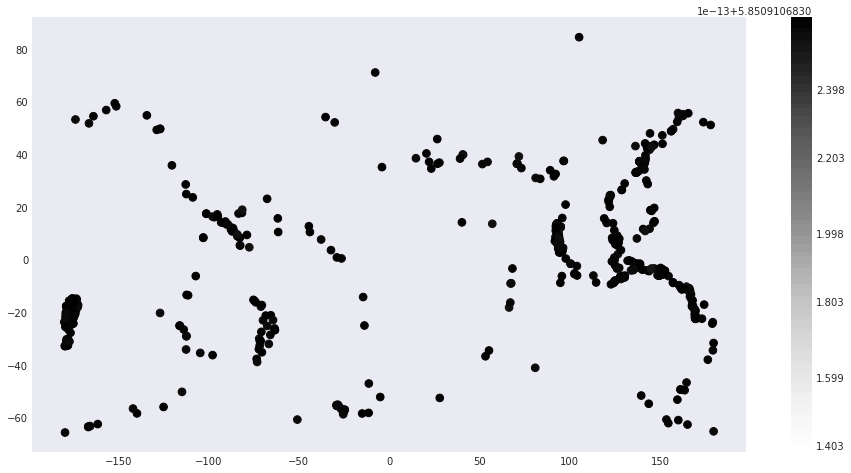

In [649]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_12,m_pos_12,node_color=_df_1.comp11,node_size = abs(_df_1.comp11)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

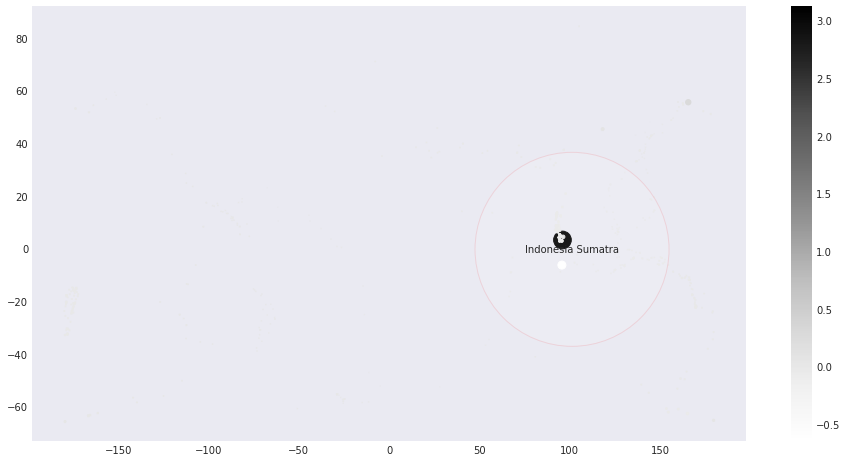

In [650]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_12,m_pos_12,node_color=_df_1.comp22,node_size = np.abs(_df_1.comp22)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

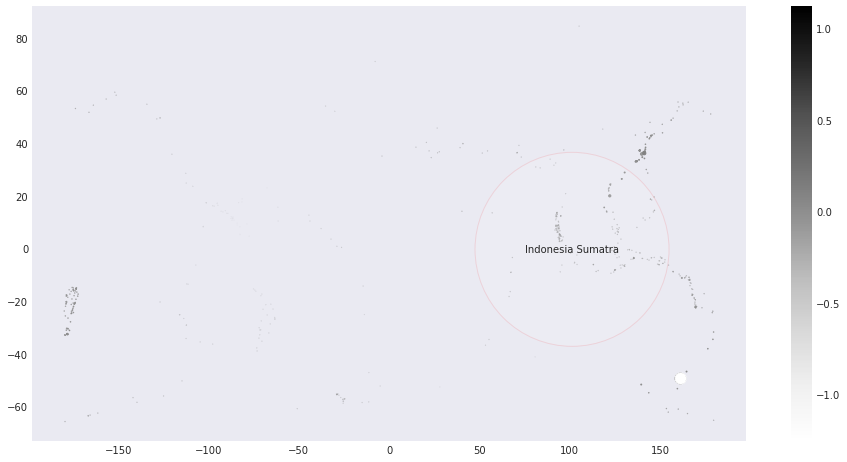

In [651]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_12,m_pos_12,node_color=_df_1.comp33,node_size = np.abs(_df_1.comp33)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

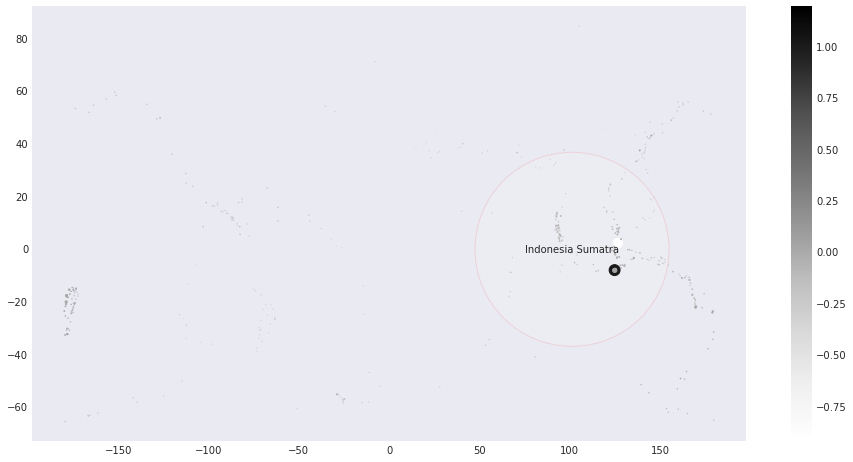

In [652]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_12,m_pos_12,node_color=_df_1.comp44,node_size = np.abs(_df_1.comp44)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

##### **$dist$를 이용한 2010년 $\theta$ = 80, $\kappa$ = 1000**

In [653]:
_G_21 = nx.Graph(W_21-np.identity(len(f_2)))

In [654]:
_pos_21 = nx.spring_layout(_G_21,iterations=20)

In [655]:
m_pos_21 = list(zip(_df_2.Longitude,_df_2.Latitude))

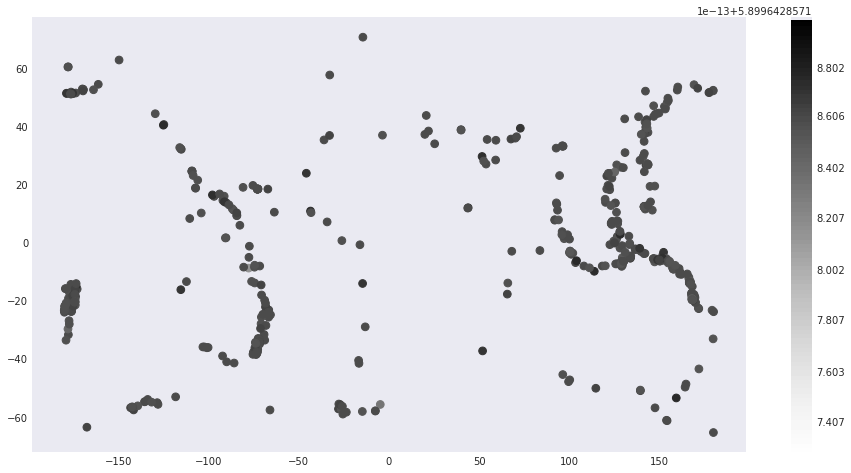

In [656]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_21,m_pos_21,node_color=_df_2.comp1,node_size = abs(_df_2.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

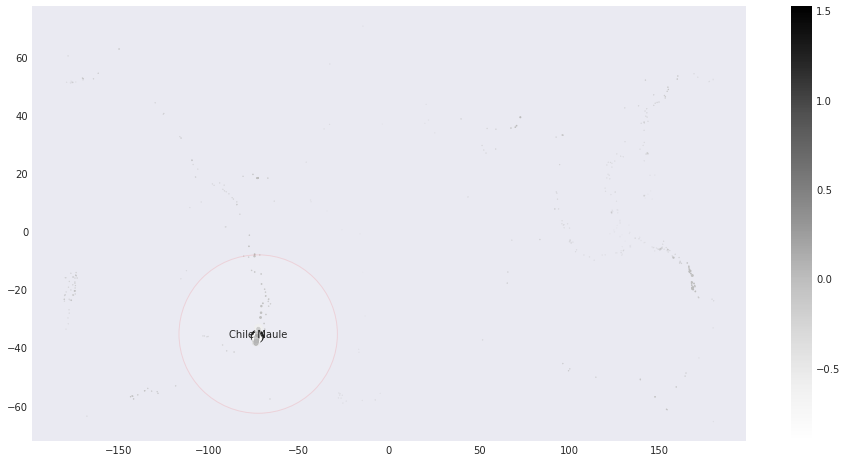

In [657]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_21,m_pos_21,node_color=_df_2.comp2,node_size = np.abs(_df_2.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

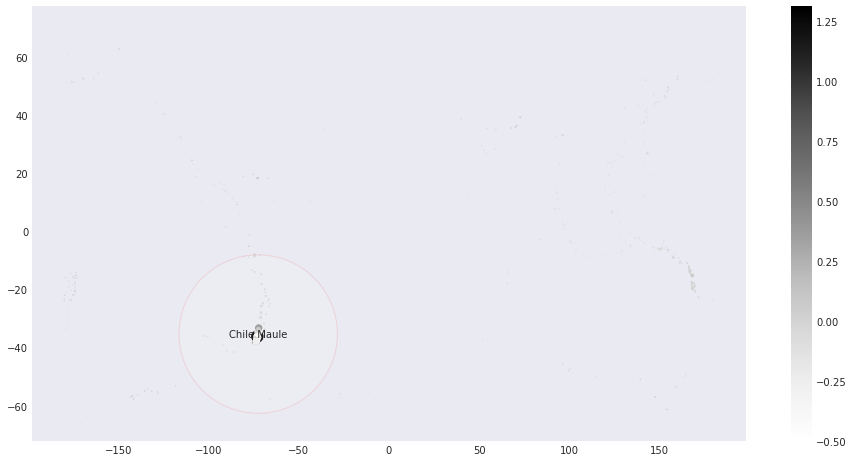

In [658]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_21,m_pos_21,node_color=_df_2.comp3,node_size = np.abs(_df_2.comp3)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

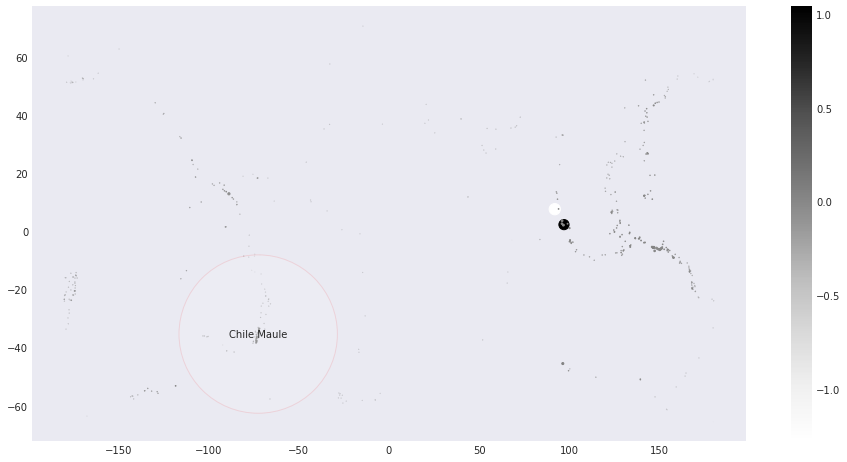

In [659]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_21,m_pos_21,node_color=_df_2.comp4,node_size = np.abs(_df_2.comp4)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

##### **$haversine$ 패키지를 이용한 2010년 $\theta$ = 100000,$\kappa$ = 100000**

In [660]:
_G_22 = nx.Graph(W_22-np.identity(len(f_2)))

In [661]:
_pos_22 = nx.spring_layout(_G_22,iterations=20)

In [662]:
m_pos_22 = list(zip(_df_2.Longitude,_df_2.Latitude))

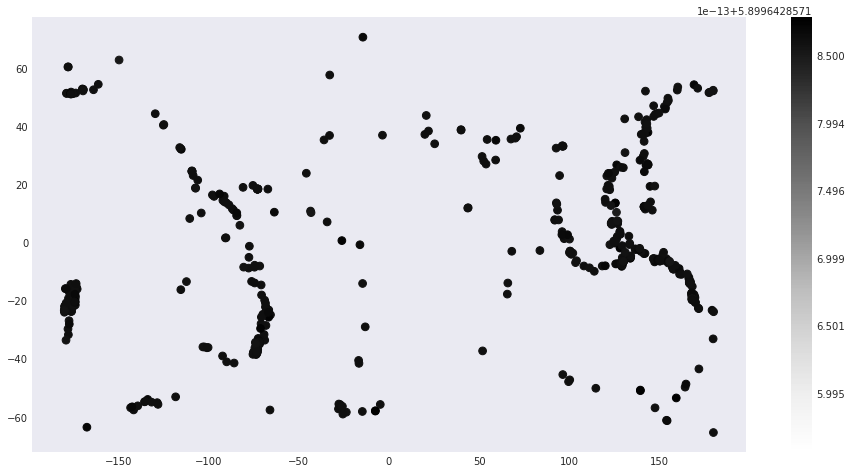

In [663]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_22,m_pos_22,node_color=_df_2.comp11,node_size = abs(_df_2.comp11)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

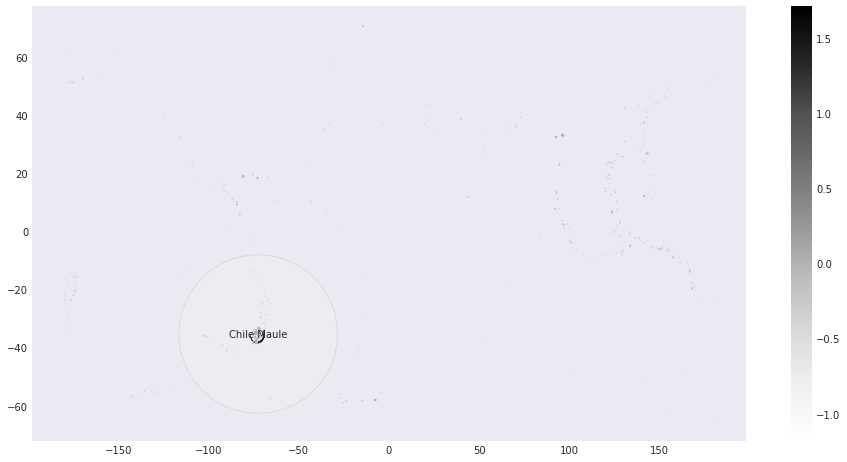

In [664]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_22,m_pos_22,node_color=_df_2.comp22,node_size = np.abs(_df_2.comp22)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

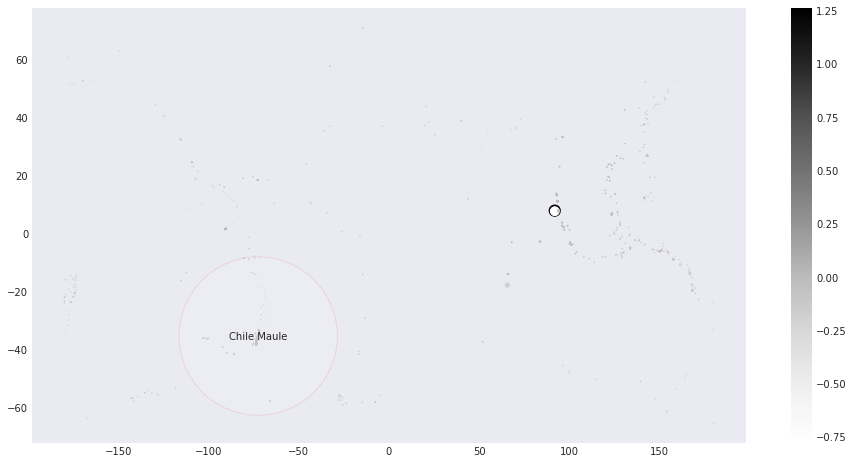

In [665]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_22,m_pos_22,node_color=_df_2.comp33,node_size = np.abs(_df_2.comp33)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

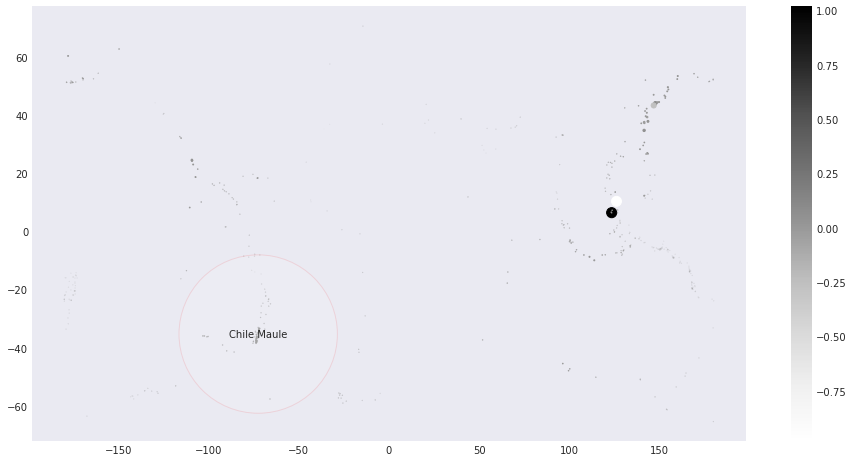

In [666]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_22,m_pos_22,node_color=_df_2.comp44,node_size = np.abs(_df_2.comp44)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

##### **$dist$를 이용한 2011년 $\theta$ = 80, $\kappa$ = 1000**

In [667]:
_G_31 = nx.Graph(W_31-np.identity(len(f_3)))

In [668]:
_pos_31 = nx.spring_layout(_G_31,iterations=20)

In [669]:
m_pos_31 = list(zip(_df_3.Longitude,_df_3.Latitude))

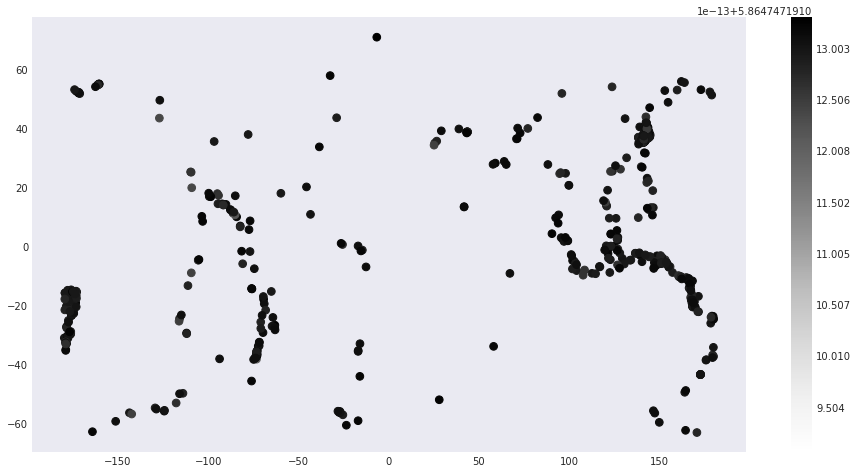

In [670]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_31,m_pos_31,node_color=_df_3.comp1,node_size = abs(_df_3.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

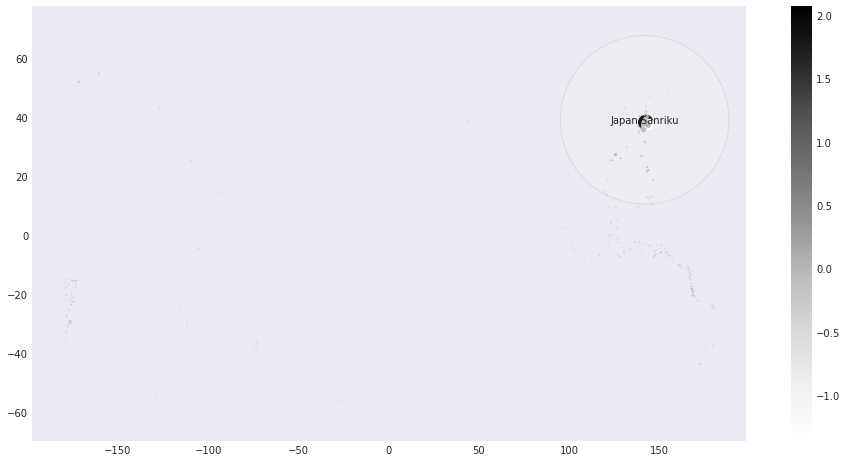

In [671]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_31,m_pos_31,node_color=_df_3.comp2,node_size = np.abs(_df_3.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

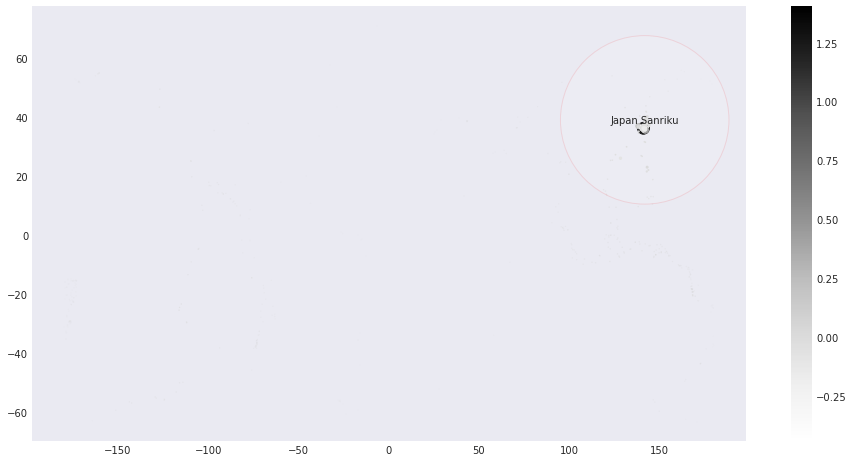

In [672]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_31,m_pos_31,node_color=_df_3.comp3,node_size = np.abs(_df_3.comp3)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

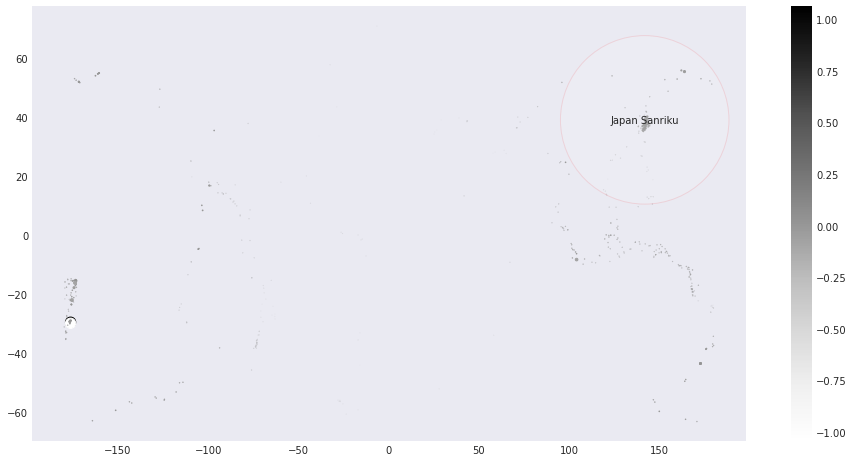

In [673]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_31,m_pos_31,node_color=_df_3.comp4,node_size = np.abs(_df_3.comp4)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

##### **$haversine$ 패키지를 이용한 2011년 $\theta$ = 100000,$\kappa$ = 100000**

In [674]:
_G_32 = nx.Graph(W_32-np.identity(len(f_3)))

In [675]:
_pos_32 = nx.spring_layout(_G_32,iterations=20)

In [676]:
m_pos_32 = list(zip(_df_3.Longitude,_df_3.Latitude))

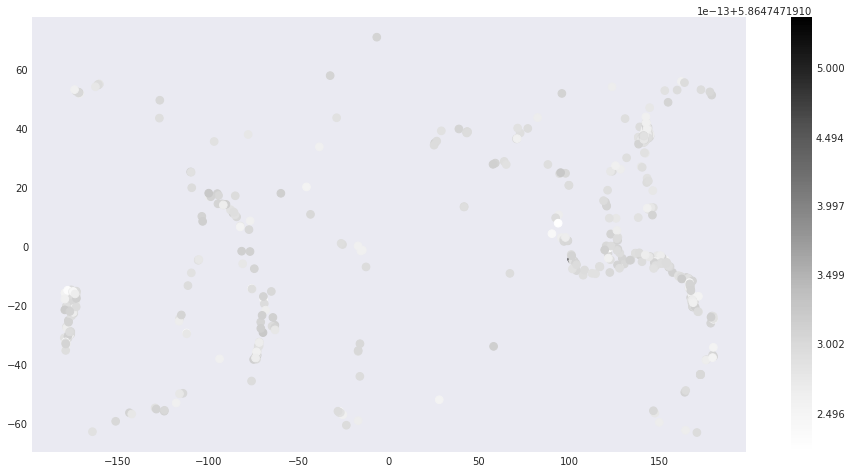

In [677]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_32,m_pos_32,node_color=_df_3.comp11,node_size = abs(_df_3.comp11)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

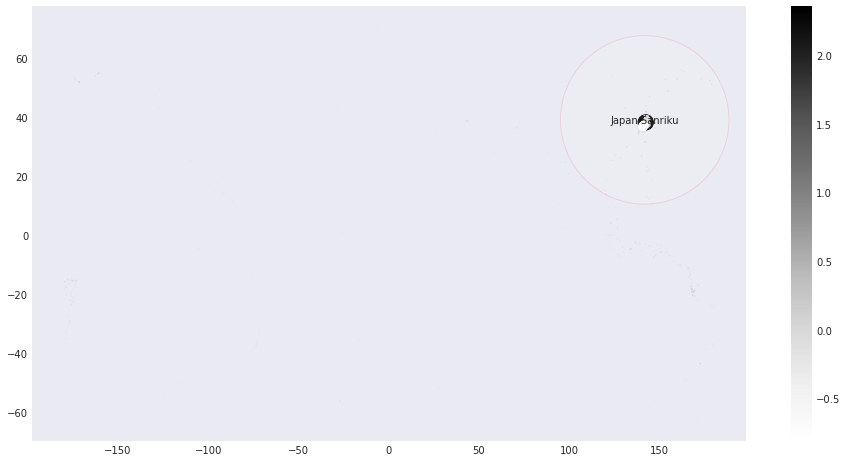

In [678]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_32,m_pos_32,node_color=_df_3.comp22,node_size = np.abs(_df_3.comp22)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

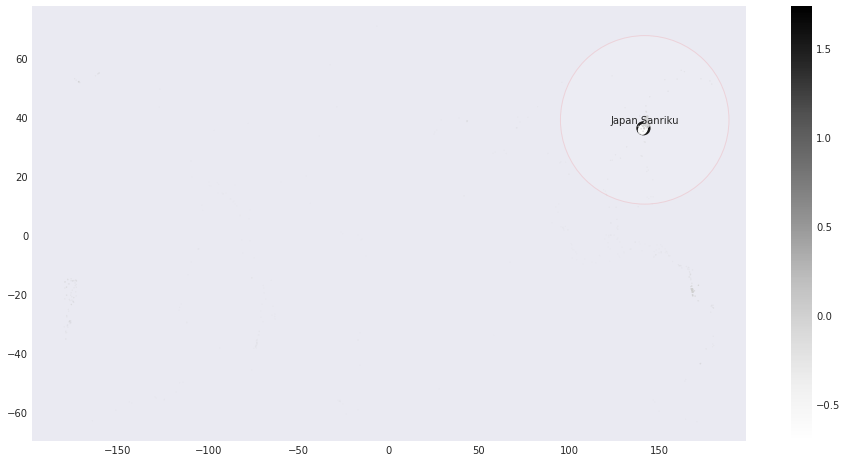

In [679]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_32,m_pos_32,node_color=_df_3.comp33,node_size = np.abs(_df_3.comp33)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

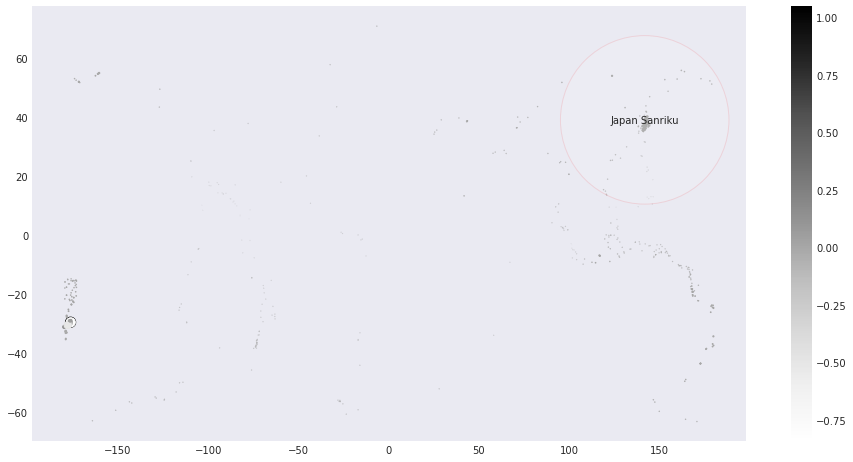

In [680]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G_32,m_pos_32,node_color=_df_3.comp44,node_size = np.abs(_df_3.comp44)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()